In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import scanpy as sc
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')
    
%load_ext autoreload
%autoreload 2

In [2]:
import scarches
from scarches.dataset import remove_sparsity
from lataq.models import TRANVAE

# Create reference data without Delta cells and query data with Delta cells

In [3]:
adata = sc.read(
    f'../data/pancreas.h5ad'
)
adata

AnnData object with n_obs × n_vars = 16382 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score'
    obsm: 'X_seurat', 'X_symphony'

In [4]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [5]:
condition_key = "study"
cell_type_keys = ["cell_type"]
remove_cts = ["beta"]
reference = ["inDrop1", 
             "inDrop2", 
             "inDrop3", 
             "inDrop4", 
             "fluidigmc1", 
             "smartseq2", 
             "smarter"]
query = ["celseq", 
         "celseq2"]

In [6]:
cell_type_key = cell_type_keys[-1]
adata = remove_sparsity(adata)
ref_adata = adata[adata.obs.study.isin(reference)].copy()
ref_adata = ref_adata[~ref_adata.obs.cell_type.isin(remove_cts)].copy()
query_adata = adata[adata.obs.study.isin(query)].copy()
adata = ref_adata.concatenate(query_adata)

#### Full Data processed

In [7]:
cts = adata.obs[cell_type_key].unique().tolist()
print(adata)
for celltype in cts:
    print(celltype, len(adata[adata.obs.cell_type.isin([celltype])]))

AnnData object with n_obs × n_vars = 12819 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'batch'
    obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
gamma 699
acinar 1669
alpha 5493
delta 1055
ductal 2142
endothelial 313
activated_stellate 464
schwann 25
mast 42
macrophage 79
epsilon 32
quiescent_stellate 193
t_cell 7
beta 606


#### Reference Data

In [8]:
cts = ref_adata.obs[cell_type_key].unique().tolist()
print(ref_adata)
for celltype in cts:
    print(celltype, len(ref_adata[ref_adata.obs.cell_type.isin([celltype])]))

AnnData object with n_obs × n_vars = 9530 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score'
    uns: 'neighbors', 'umap'
    obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'
gamma 571
acinar 1167
alpha 4459
delta 802
ductal 1557
endothelial 287
activated_stellate 355
schwann 20
mast 35
macrophage 63
epsilon 27
quiescent_stellate 180
t_cell 7


#### Query Data

In [9]:
cts = query_adata.obs[cell_type_key].unique().tolist()
print(query_adata)
for celltype in cts:
    print(celltype, len(query_adata[query_adata.obs.cell_type.isin([celltype])]))

AnnData object with n_obs × n_vars = 3289 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score'
    uns: 'neighbors', 'umap'
    obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'
gamma 128
acinar 502
alpha 1034
delta 253
beta 606
ductal 585
endothelial 26
activated_stellate 109
schwann 5
mast 7
macrophage 16
epsilon 5
quiescent_stellate 13


#### Use the next cell only to simulate a semi labeled reference

In [10]:
#cells_per_ct = 500
#cell_type_key = "cell_type"
#
#indices = np.arange(len(ref_adata))
#labeled_ind = []
#cts = ref_adata.obs[cell_type_key].unique().tolist()
#for celltype in cts:
#    ct_indices = indices[ref_adata.obs[cell_type_key].isin([celltype])]
#    ct_sample_size = cells_per_ct
#    if cells_per_ct > len(ct_indices):
#        ct_sample_size = len(ct_indices)
#    ct_sel_ind = np.random.choice(
#        ct_indices, 
#        size=ct_sample_size, 
#        replace=False
#    )
#    labeled_ind += ct_sel_ind.tolist()
#    print(celltype, len(ct_indices), len(ct_sel_ind), len(labeled_ind))

# Supervised Reference Training (100% labels used)

In [11]:
tranvae_ref = TRANVAE(
    adata=ref_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_keys,
    hidden_layer_sizes=[128, 128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 7
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 7
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [12]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_landmark_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

tranvae_ref.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=400,
    alpha_epoch_anneal=1e3,
    eta=1,
    unlabeled_weight=0.1,
    clustering_res=2,
)

 |█████████████████---| 89.6%  - val_loss: 1033.1465072632 - val_trvae_loss: 1030.9356002808 - val_landmark_loss: 2.2108939290 - val_labeled_loss: 2.2108939290
ADJUSTED LR
 |██████████████████--| 91.0%  - val_loss: 1029.8822937012 - val_trvae_loss: 1027.6107864380 - val_landmark_loss: 2.2715063989 - val_labeled_loss: 2.2715063989
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 433


# Unsupervised Query Training (0 labels used)

In [13]:
tranvae = TRANVAE.load_query_data(
    adata=query_adata,
    reference_model=tranvae_ref,
    labeled_indices=[],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 9
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [14]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

tranvae.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=400,
    eta=1,
    unlabeled_weight=0.1,
    weight_decay=0,
    clustering_res=2,
)

Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
 |████████████████----| 80.0%  - val_loss: 1662.2984212240 - val_trvae_loss: 1662.2984212240
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 21 clusters.
 |█████████████████---| 88.0%  - val_loss: 1661.1449381510 - val_trvae_loss: 1661.0055338542 - val_landmark_loss: 0.1394116183 - val_unlabeled_loss: 1.3941161633
ADJUSTED LR
 |█████████████████---| 89.4%  - val_loss: 1664.2873535156 - val_trvae_loss: 1664.1378987630 - val_landmark_loss: 0.1494471853 - val_unlabeled_loss: 1.4944718281
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 425


In [15]:
tranvae.save(
    'tmp',
    overwrite=True
)

# Reloading point if trained model already exists

In [16]:
tranvae = TRANVAE.load(
    dir_path='tmp',
    adata=query_adata,
)

AnnData object with n_obs × n_vars = 3289 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'trvae_size_factors', 'trvae_labeled'
    uns: 'neighbors', 'umap'
    obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 9
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



# Visualizing resulting adata latent representation and landmarks

#### Unlabeled Query Data accuracy

In [17]:
def detect_threshold(probs, labels):
    candidates = np.linspace(np.min(probs), np.max(probs), 1000)
    accs = []
    for thr in candidates:
        outcome = (probs > thr)
        acc = np.sum((outcome == labels)) / len(outcome)
        accs.append(acc)
    return accs, candidates

In [18]:
results_dict_q = tranvae.classify(
    #metric="euclidean"
)

preds_q = results_dict_q[cell_type_key]['preds']
probs_q = results_dict_q[cell_type_key]['probs']
print(classification_report(
    y_true=query_adata.obs[cell_type_key],
    y_pred=preds_q,
    labels=np.array(query_adata.obs[cell_type_key].unique().tolist())
))

                    precision    recall  f1-score   support

             gamma       0.83      1.00      0.91       128
            acinar       0.96      0.86      0.91       502
             alpha       1.00      0.97      0.98      1034
             delta       0.30      0.99      0.46       253
              beta       0.00      0.00      0.00       606
            ductal       0.87      0.98      0.92       585
       endothelial       1.00      1.00      1.00        26
activated_stellate       0.88      1.00      0.94       109
           schwann       1.00      1.00      1.00         5
              mast       1.00      0.71      0.83         7
        macrophage       1.00      0.94      0.97        16
           epsilon       1.00      0.80      0.89         5
quiescent_stellate       1.00      0.46      0.63        13

          accuracy                           0.78      3289
         macro avg       0.83      0.82      0.80      3289
      weighted avg       0.72      0.7

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

['gamma' 'gamma' 'gamma' 'gamma' 'gamma' 'gamma' 'gamma' ...
 'activated_stellate' 'activated_stellate' 'quiescent_stellate'
 'activated_stellate' 'quiescent_stellate' 'activated_stellate'
 'activated_stellate']
                    precision    recall  f1-score   support

             gamma       0.84      0.99      0.91       128
            acinar       0.96      0.84      0.89       502
             alpha       0.99      0.97      0.98      1034
             delta       0.30      0.99      0.46       253
              beta       0.00      0.00      0.00       606
            ductal       0.86      0.98      0.92       585
       endothelial       0.96      1.00      0.98        26
activated_stellate       0.89      1.00      0.94       109
           schwann       1.00      1.00      1.00         5
              mast       1.00      0.71      0.83         7
        macrophage       1.00      0.94      0.97        16
           epsilon       0.67      0.80      0.73         5
quiesce

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

<AxesSubplot:xlabel='cell_type_prob'>

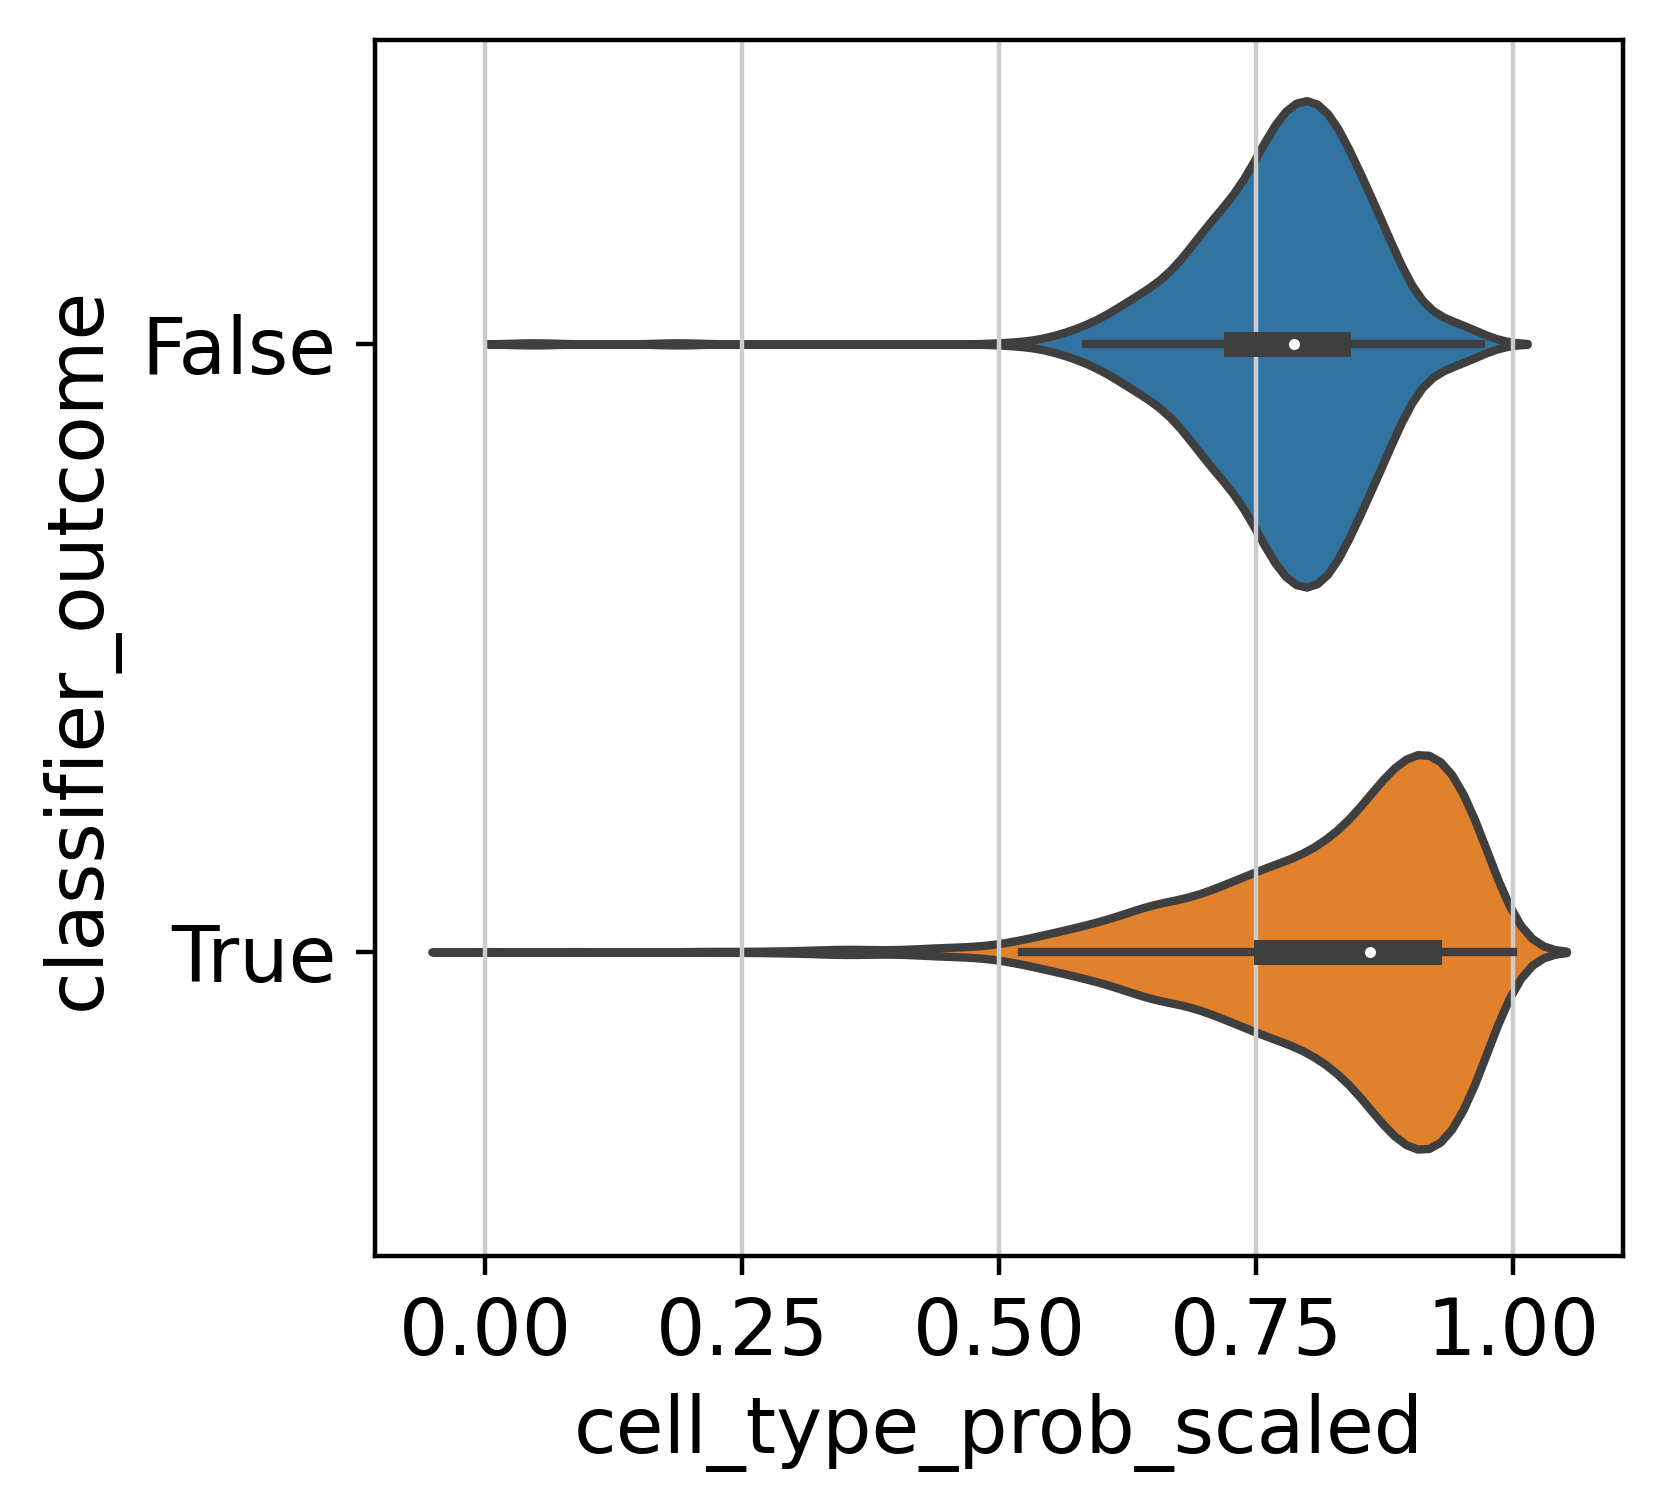

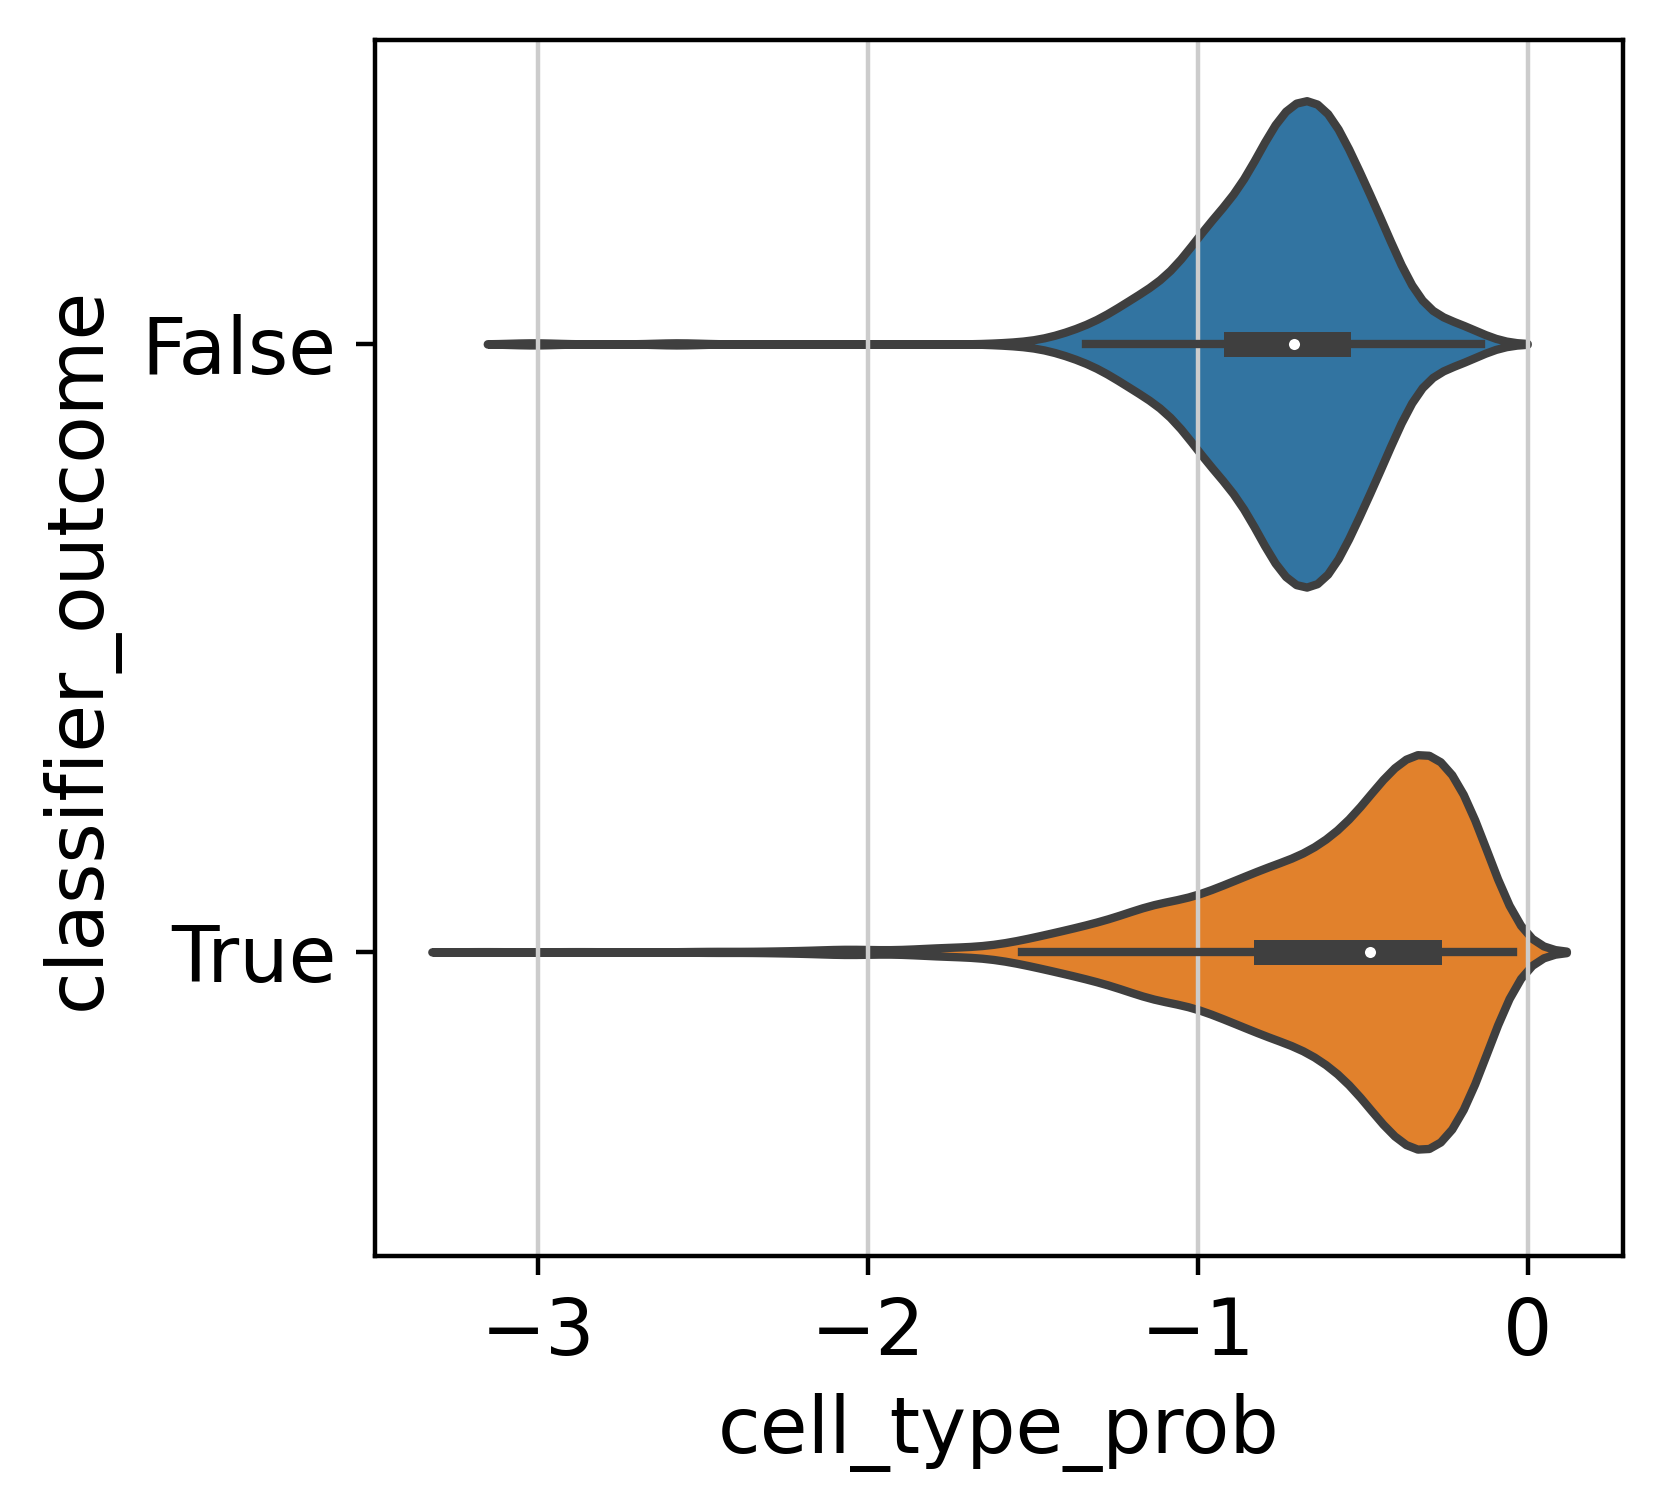

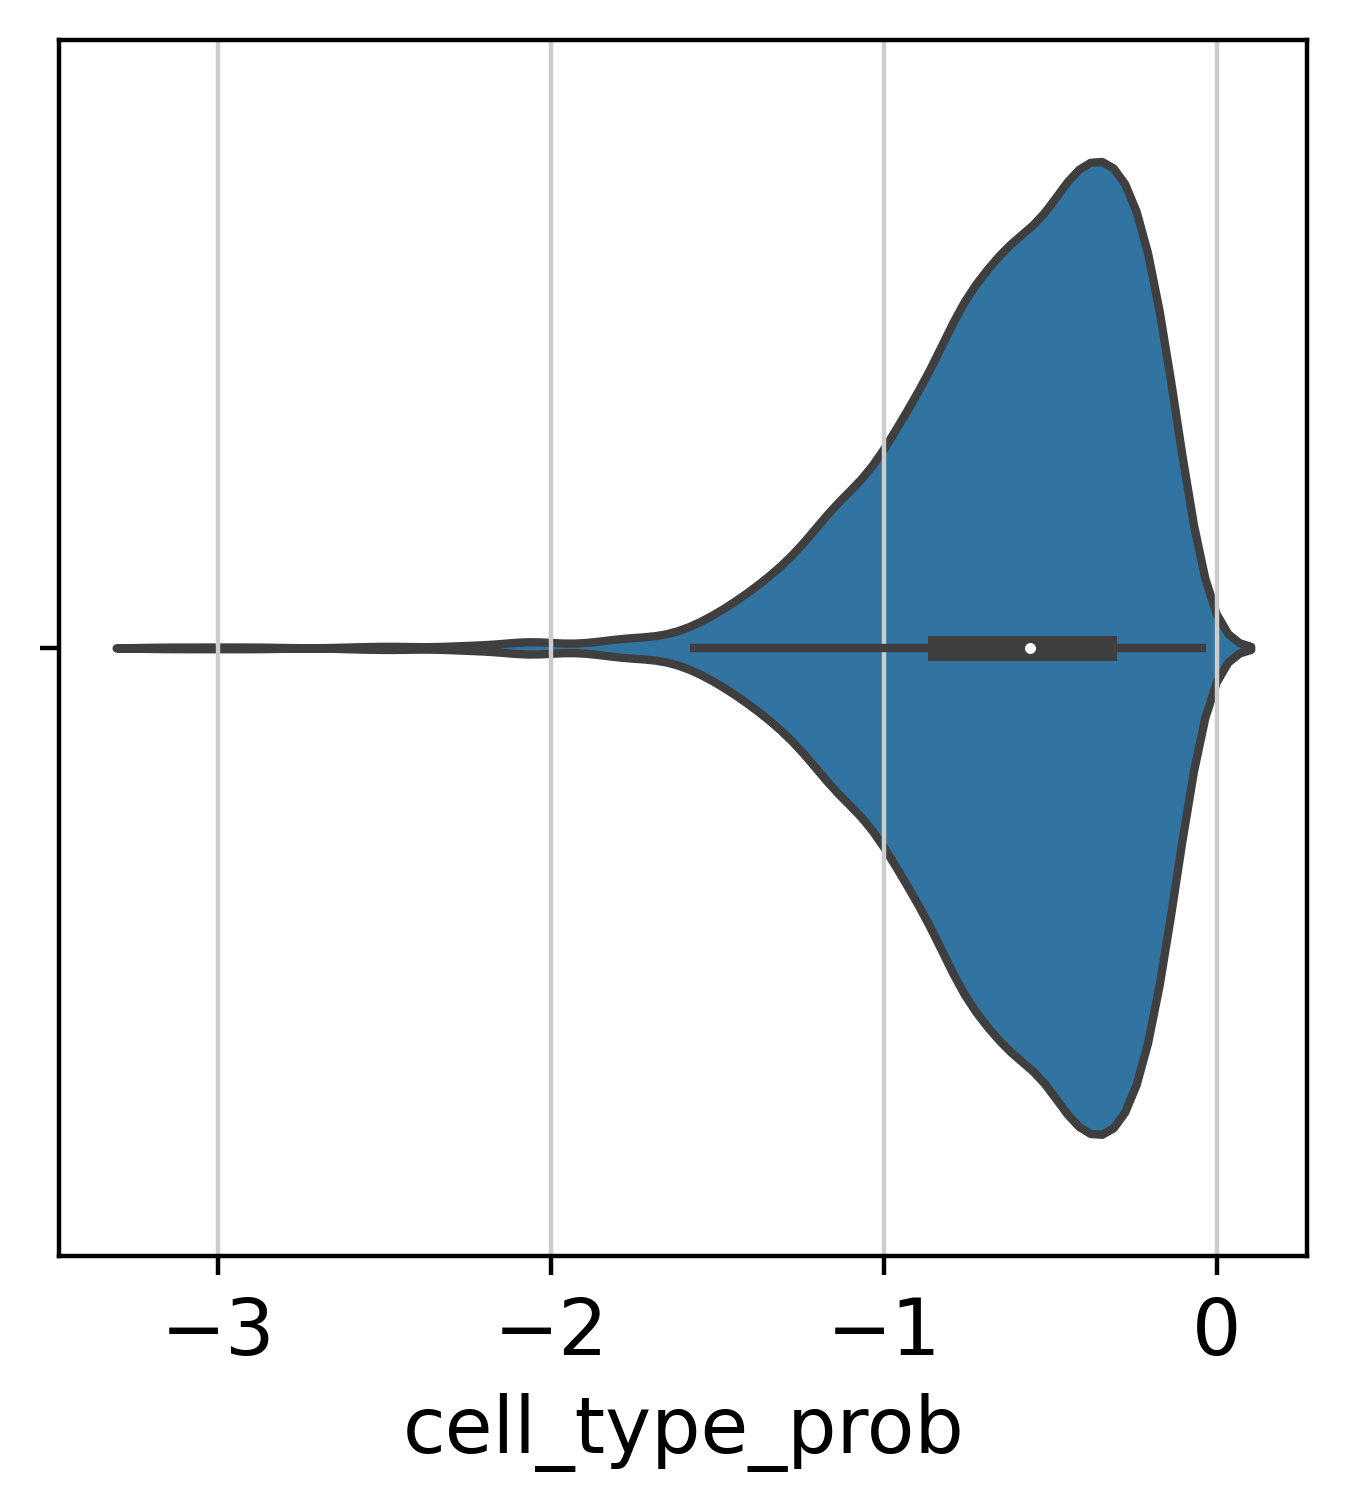

In [19]:
results_dict_q = tranvae.classify(
    metric="dist",
    get_prob=False,
    threshold=-1e10
)

preds_q = results_dict_q[cell_type_key]['preds']
print(preds_q)
probs_q = results_dict_q[cell_type_key]['probs']
print(classification_report(
    y_true=query_adata.obs[cell_type_key],
    y_pred=preds_q,
    labels=np.array(query_adata.obs[cell_type_key].unique().tolist())
))

data_latent = tranvae.get_latent()
adata_latent = sc.AnnData(data_latent)
adata_latent.obs[condition_key] = query_adata.obs[condition_key].tolist()
adata_latent.obs[cell_type_key] = query_adata.obs[cell_type_key].tolist()
adata_latent.obs[f'{cell_type_key}_pred'] = preds_q.tolist()
adata_latent.obs[f'{cell_type_key}_prob'] = probs_q.tolist()
adata_latent.obs[f'classifier_outcome'] = (
    adata_latent.obs[f'{cell_type_key}_pred'] == adata_latent.obs[f'{cell_type_key}']
)
probs_scaled = (probs_q - probs_q.min(axis=0)) / (probs_q.max(axis=0) - probs_q.min(axis=0))

adata_latent.obs[f'{cell_type_key}_prob_scaled'] = probs_scaled
sns.violinplot(
    x=adata_latent.obs['cell_type_prob_scaled'], 
    y=adata_latent.obs['classifier_outcome'].astype('category')
)
plt.figure()
sns.violinplot(
    x=adata_latent.obs['cell_type_prob'], 
    y=adata_latent.obs['classifier_outcome'].astype('category')
)
plt.figure()
sns.violinplot(
    x=adata_latent.obs['cell_type_prob'], 
)

In [20]:
accs, candidates = detect_threshold(adata_latent.obs['cell_type_prob'], adata_latent.obs['classifier_outcome'])

In [21]:
candidates[np.argmax(accs)]

-3.012677728883676

(0.0, 1.0)

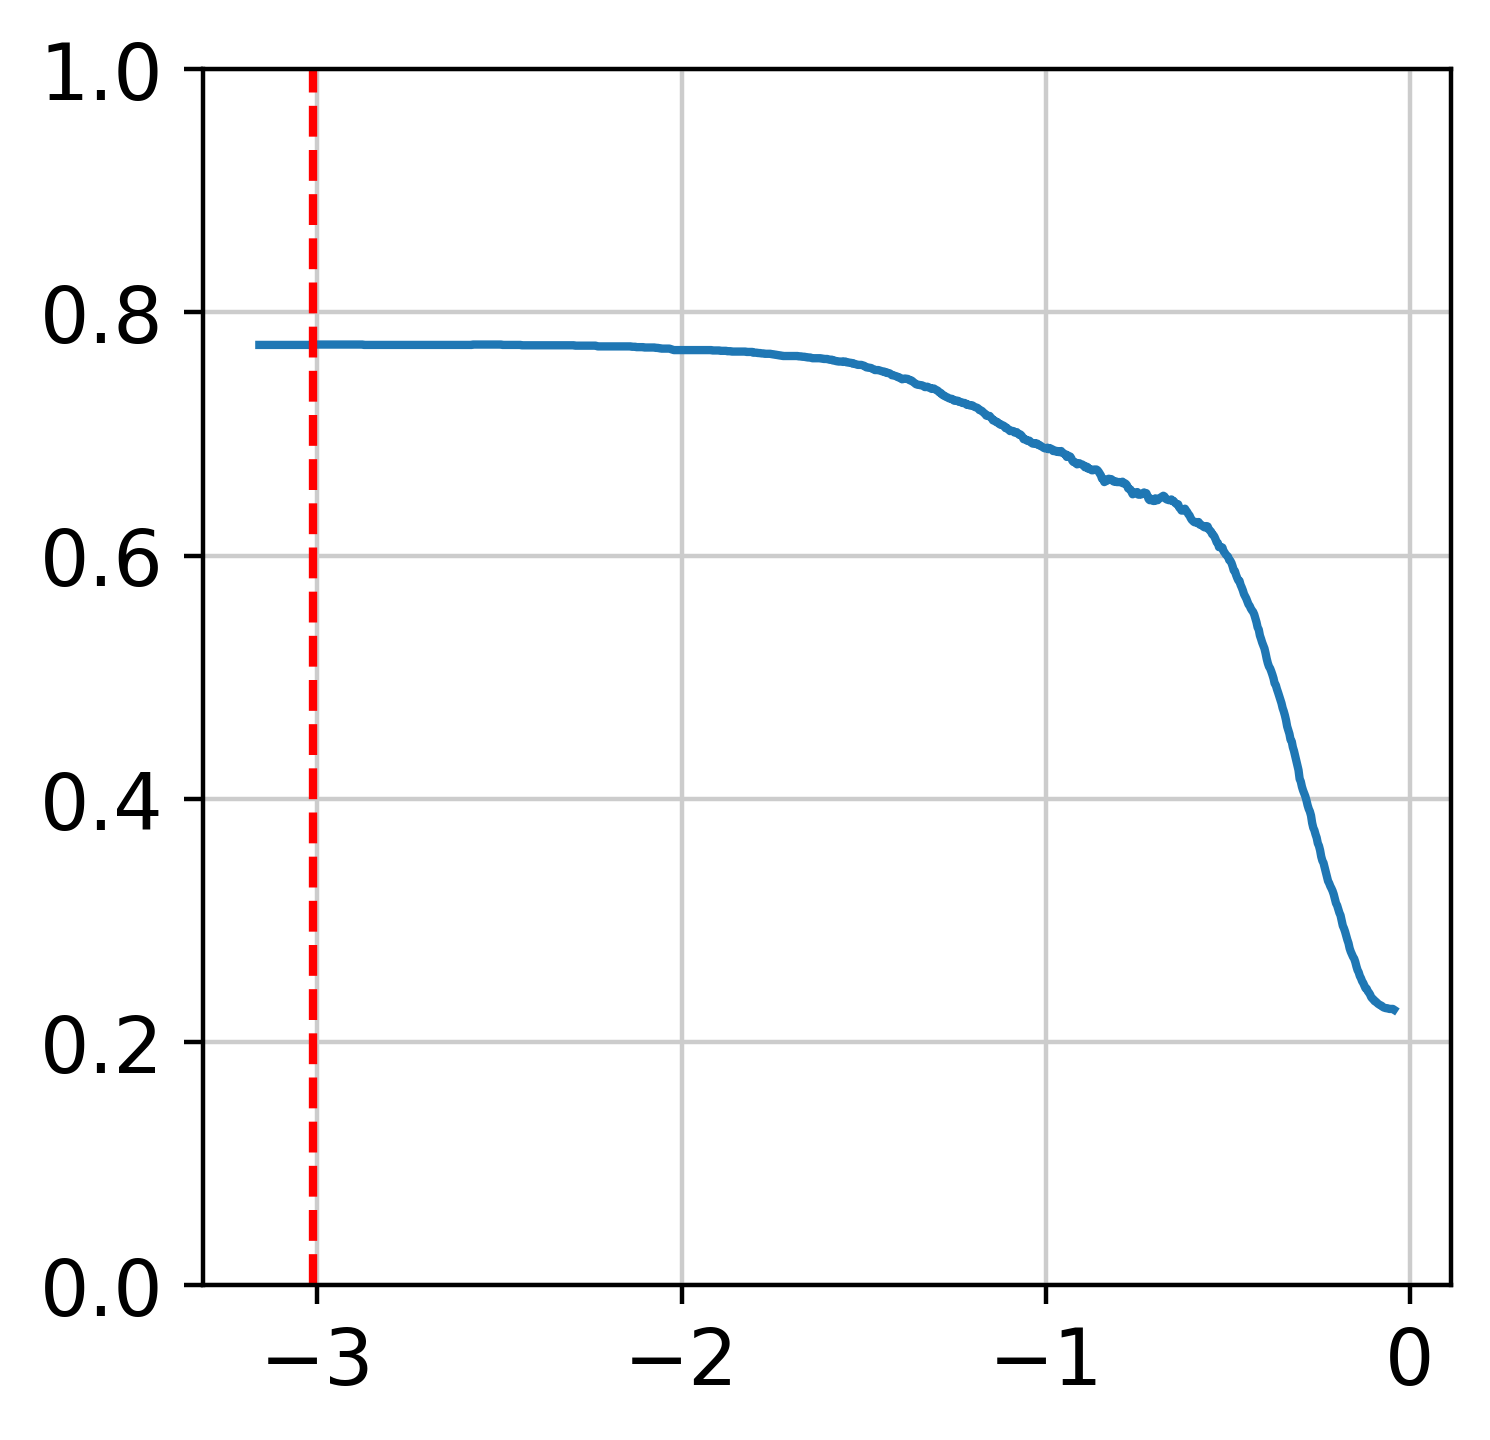

In [22]:
plt.plot(candidates, accs)
plt.axvline(candidates[np.argmax(accs)], color='r', linestyle='--')
plt.ylim([0, 1])

['gamma' 'gamma' 'gamma' 'gamma' 'gamma' 'gamma' 'gamma' ...
 'activated_stellate' 'activated_stellate' 'quiescent_stellate'
 'activated_stellate' 'quiescent_stellate' 'activated_stellate'
 'quiescent_stellate']
                    precision    recall  f1-score   support

             gamma       0.82      1.00      0.90       128
            acinar       0.96      0.86      0.91       502
             alpha       0.99      0.97      0.98      1034
             delta       0.30      1.00      0.46       253
              beta       0.00      0.00      0.00       606
            ductal       0.88      0.98      0.93       585
       endothelial       1.00      1.00      1.00        26
activated_stellate       0.90      1.00      0.95       109
           schwann       1.00      1.00      1.00         5
              mast       1.00      0.71      0.83         7
        macrophage       1.00      0.94      0.97        16
           epsilon       0.80      0.80      0.80         5
quiesce

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

<AxesSubplot:xlabel='cell_type_prob'>

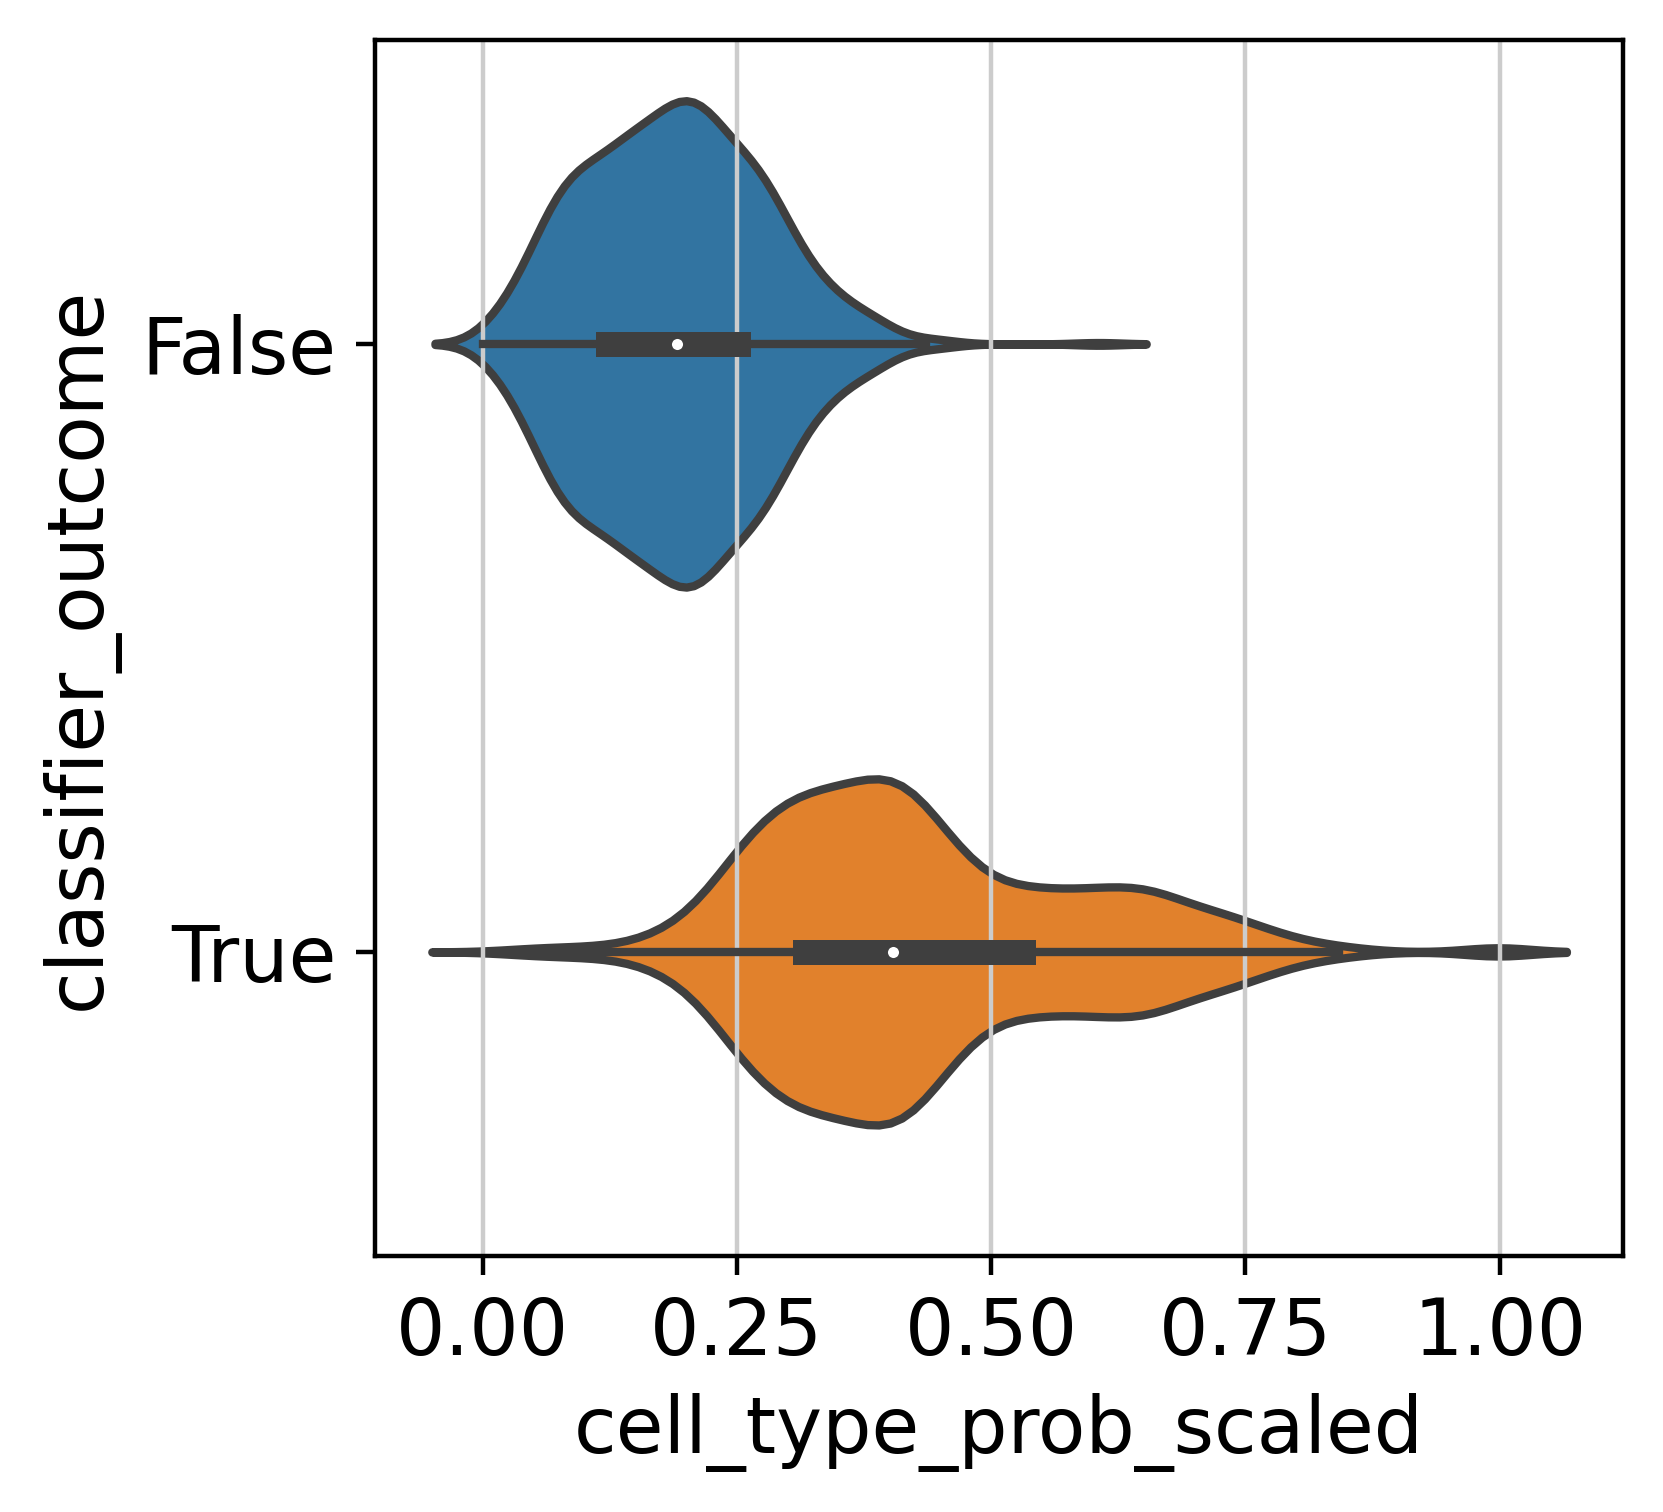

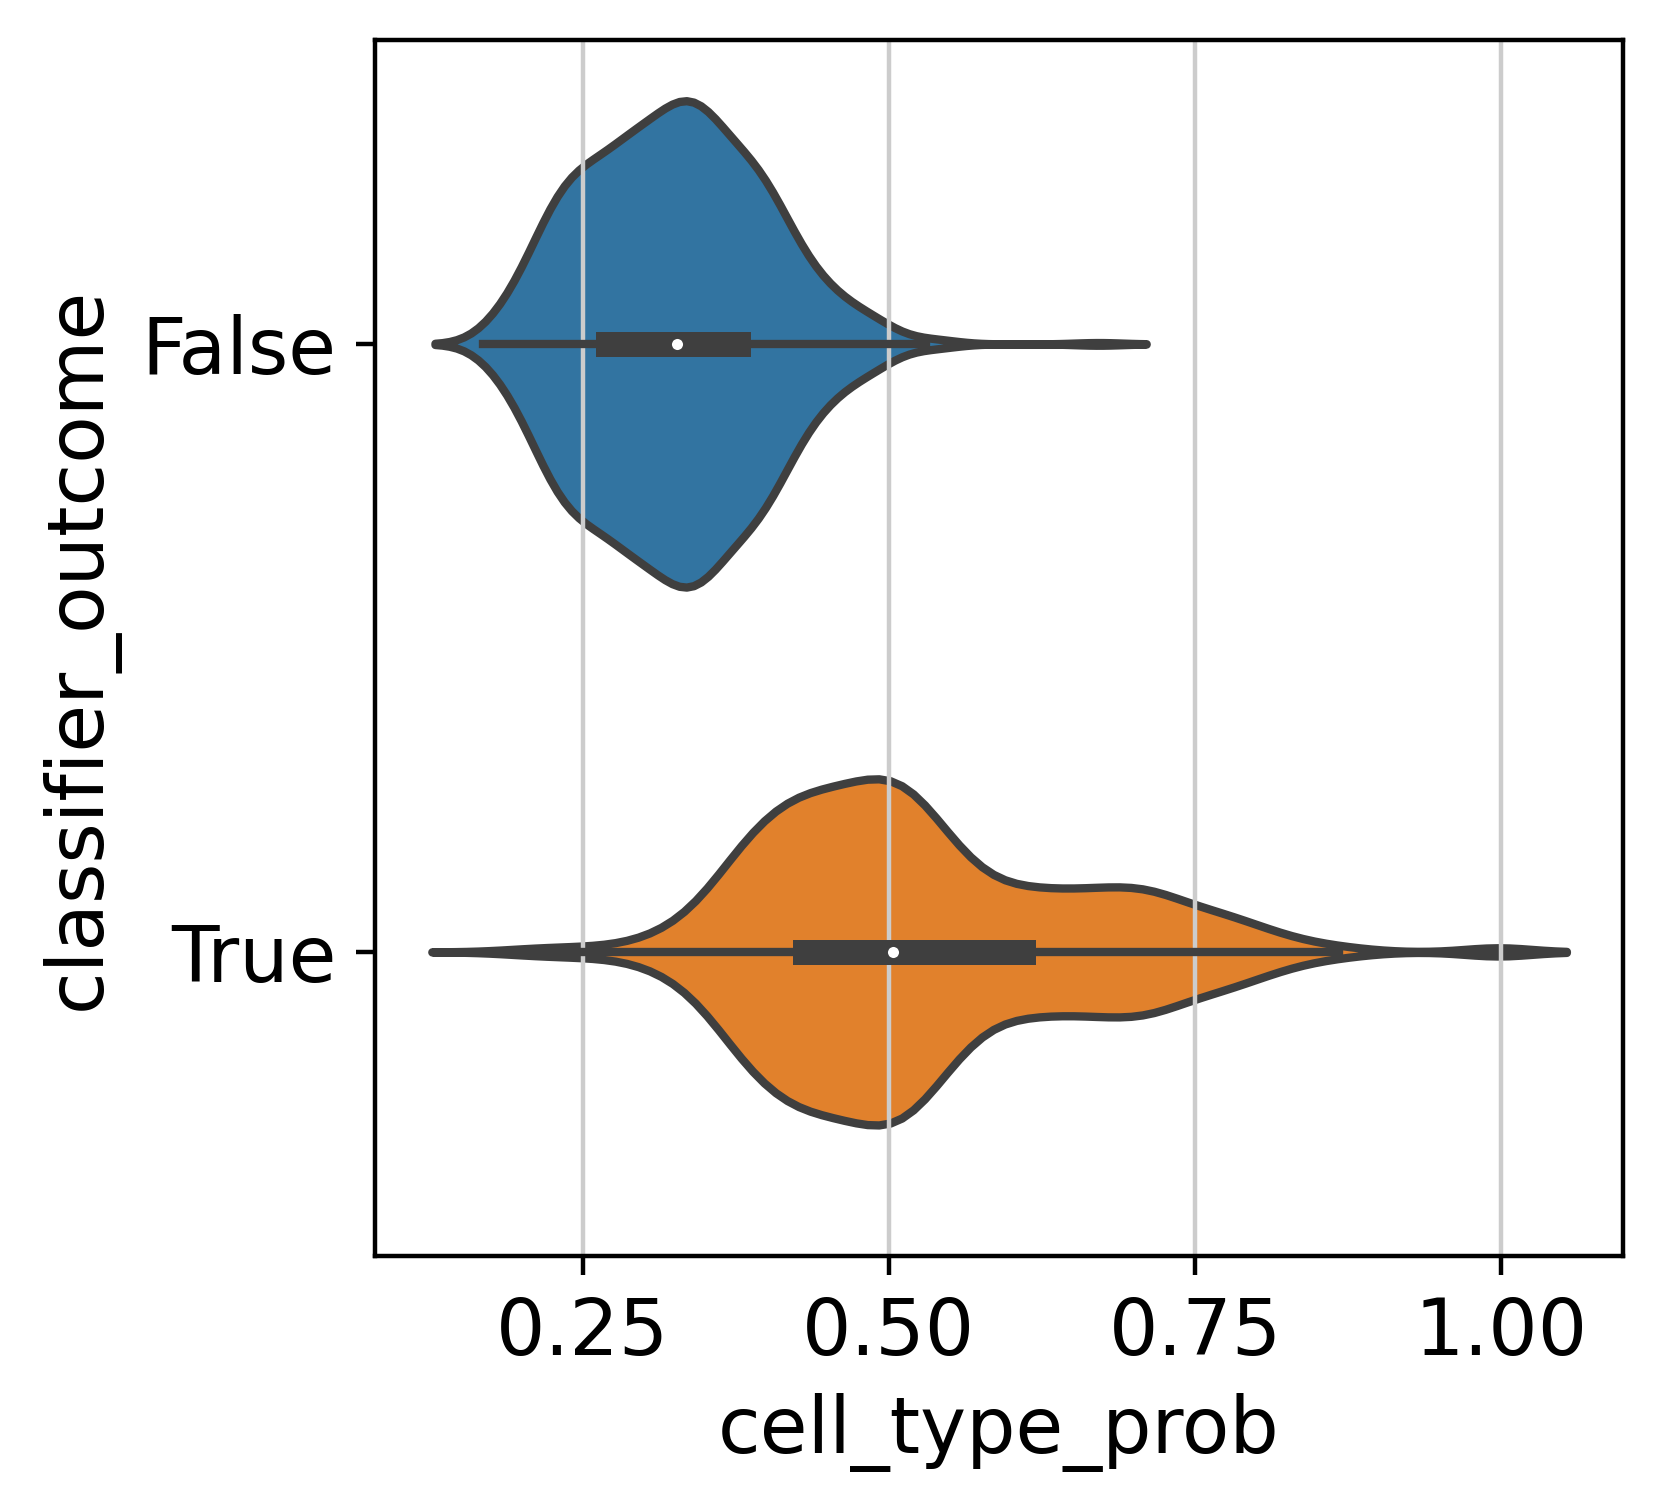

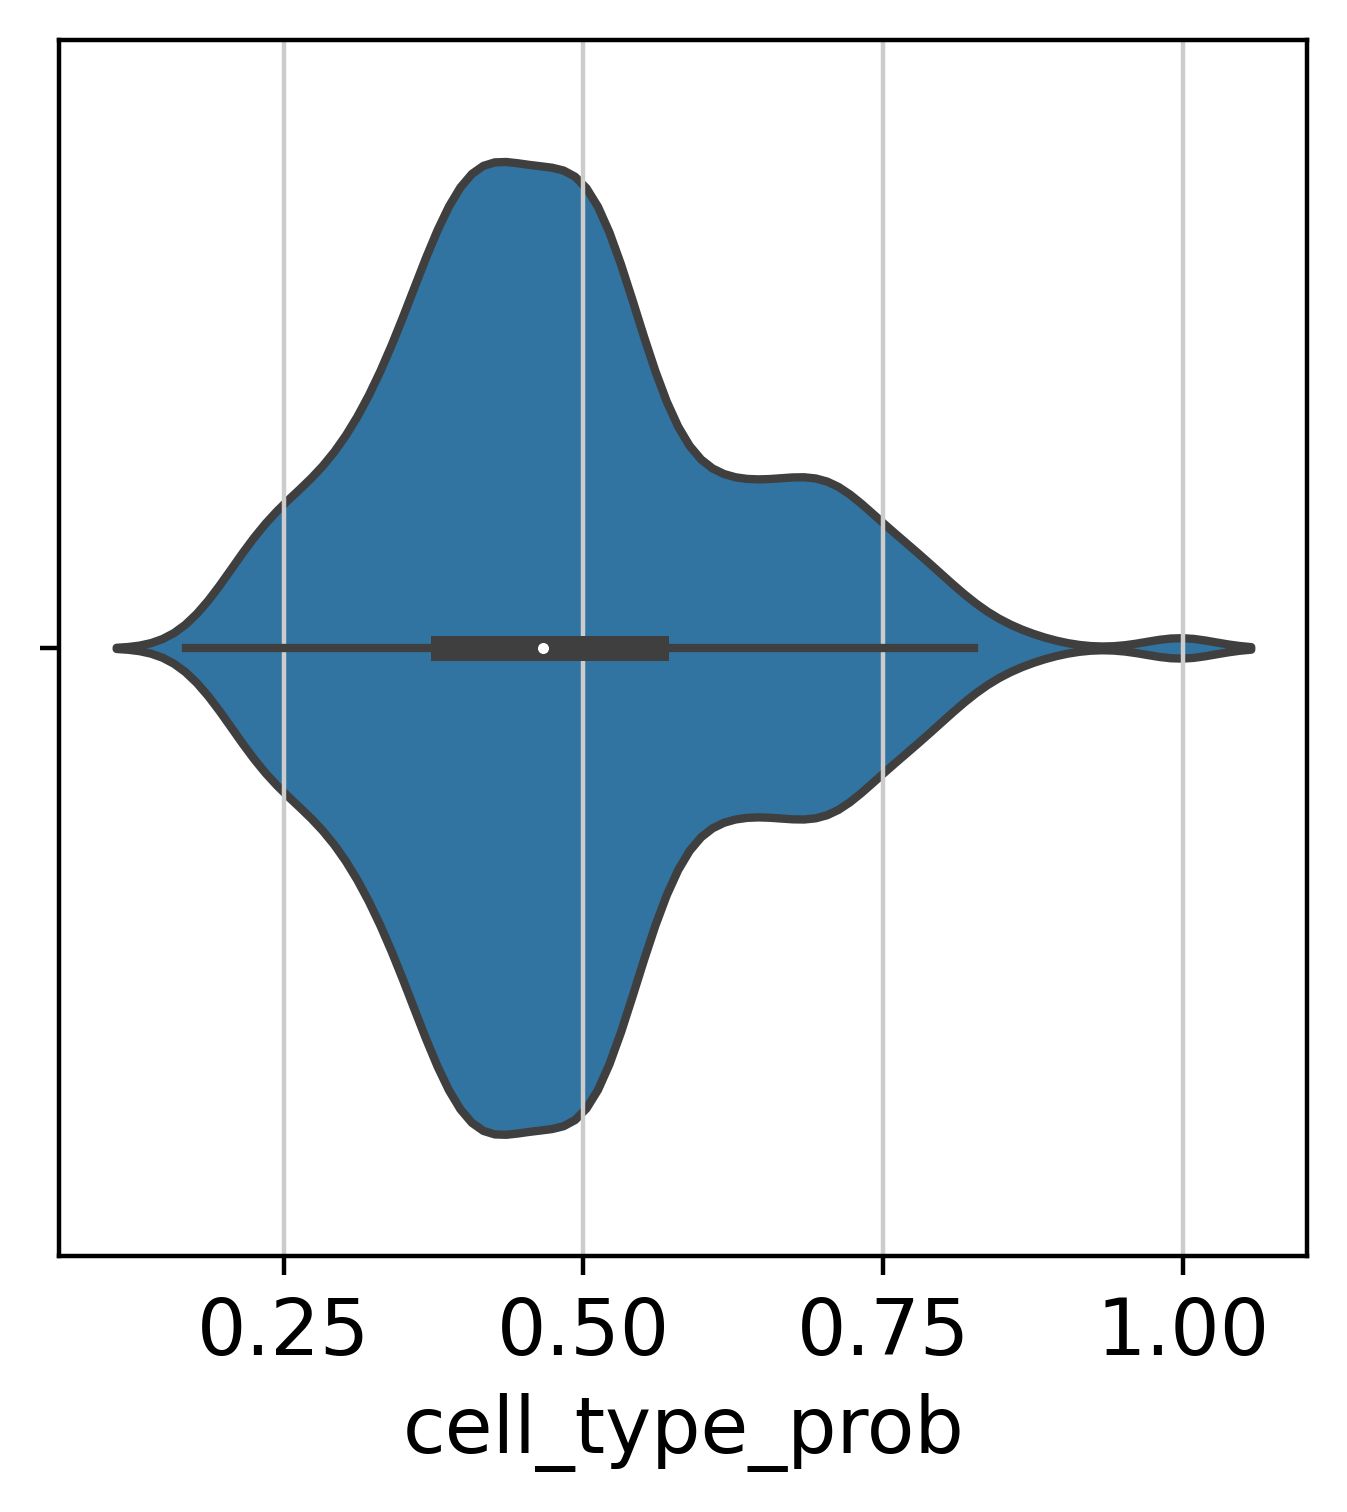

In [23]:
results_dict_q = tranvae.classify(
    metric="dist",
    get_prob=True,
    threshold=-1e10
)

preds_q = results_dict_q[cell_type_key]['preds']
print(preds_q)
probs_q = results_dict_q[cell_type_key]['probs']
print(classification_report(
    y_true=query_adata.obs[cell_type_key],
    y_pred=preds_q,
    labels=np.array(query_adata.obs[cell_type_key].unique().tolist())
))

data_latent = tranvae.get_latent()
adata_latent = sc.AnnData(data_latent)
adata_latent.obs[condition_key] = query_adata.obs[condition_key].tolist()
adata_latent.obs[cell_type_key] = query_adata.obs[cell_type_key].tolist()
adata_latent.obs[f'{cell_type_key}_pred'] = preds_q.tolist()
adata_latent.obs[f'{cell_type_key}_prob'] = probs_q.tolist()
adata_latent.obs[f'classifier_outcome'] = (
    adata_latent.obs[f'{cell_type_key}_pred'] == adata_latent.obs[f'{cell_type_key}']
)
probs_scaled = (probs_q - probs_q.min(axis=0)) / (probs_q.max(axis=0) - probs_q.min(axis=0))

adata_latent.obs[f'{cell_type_key}_prob_scaled'] = probs_scaled
sns.violinplot(
    x=adata_latent.obs['cell_type_prob_scaled'], 
    y=adata_latent.obs['classifier_outcome'].astype('category')
)
plt.figure()
sns.violinplot(
    x=adata_latent.obs['cell_type_prob'], 
    y=adata_latent.obs['classifier_outcome'].astype('category')
)
plt.figure()
sns.violinplot(
    x=adata_latent.obs['cell_type_prob'], 
)

In [24]:
accs, candidates = detect_threshold(adata_latent.obs['cell_type_prob'], adata_latent.obs['classifier_outcome'])

In [25]:
candidates[np.argmax(accs)]

0.3612000849303063

(0.0, 1.0)

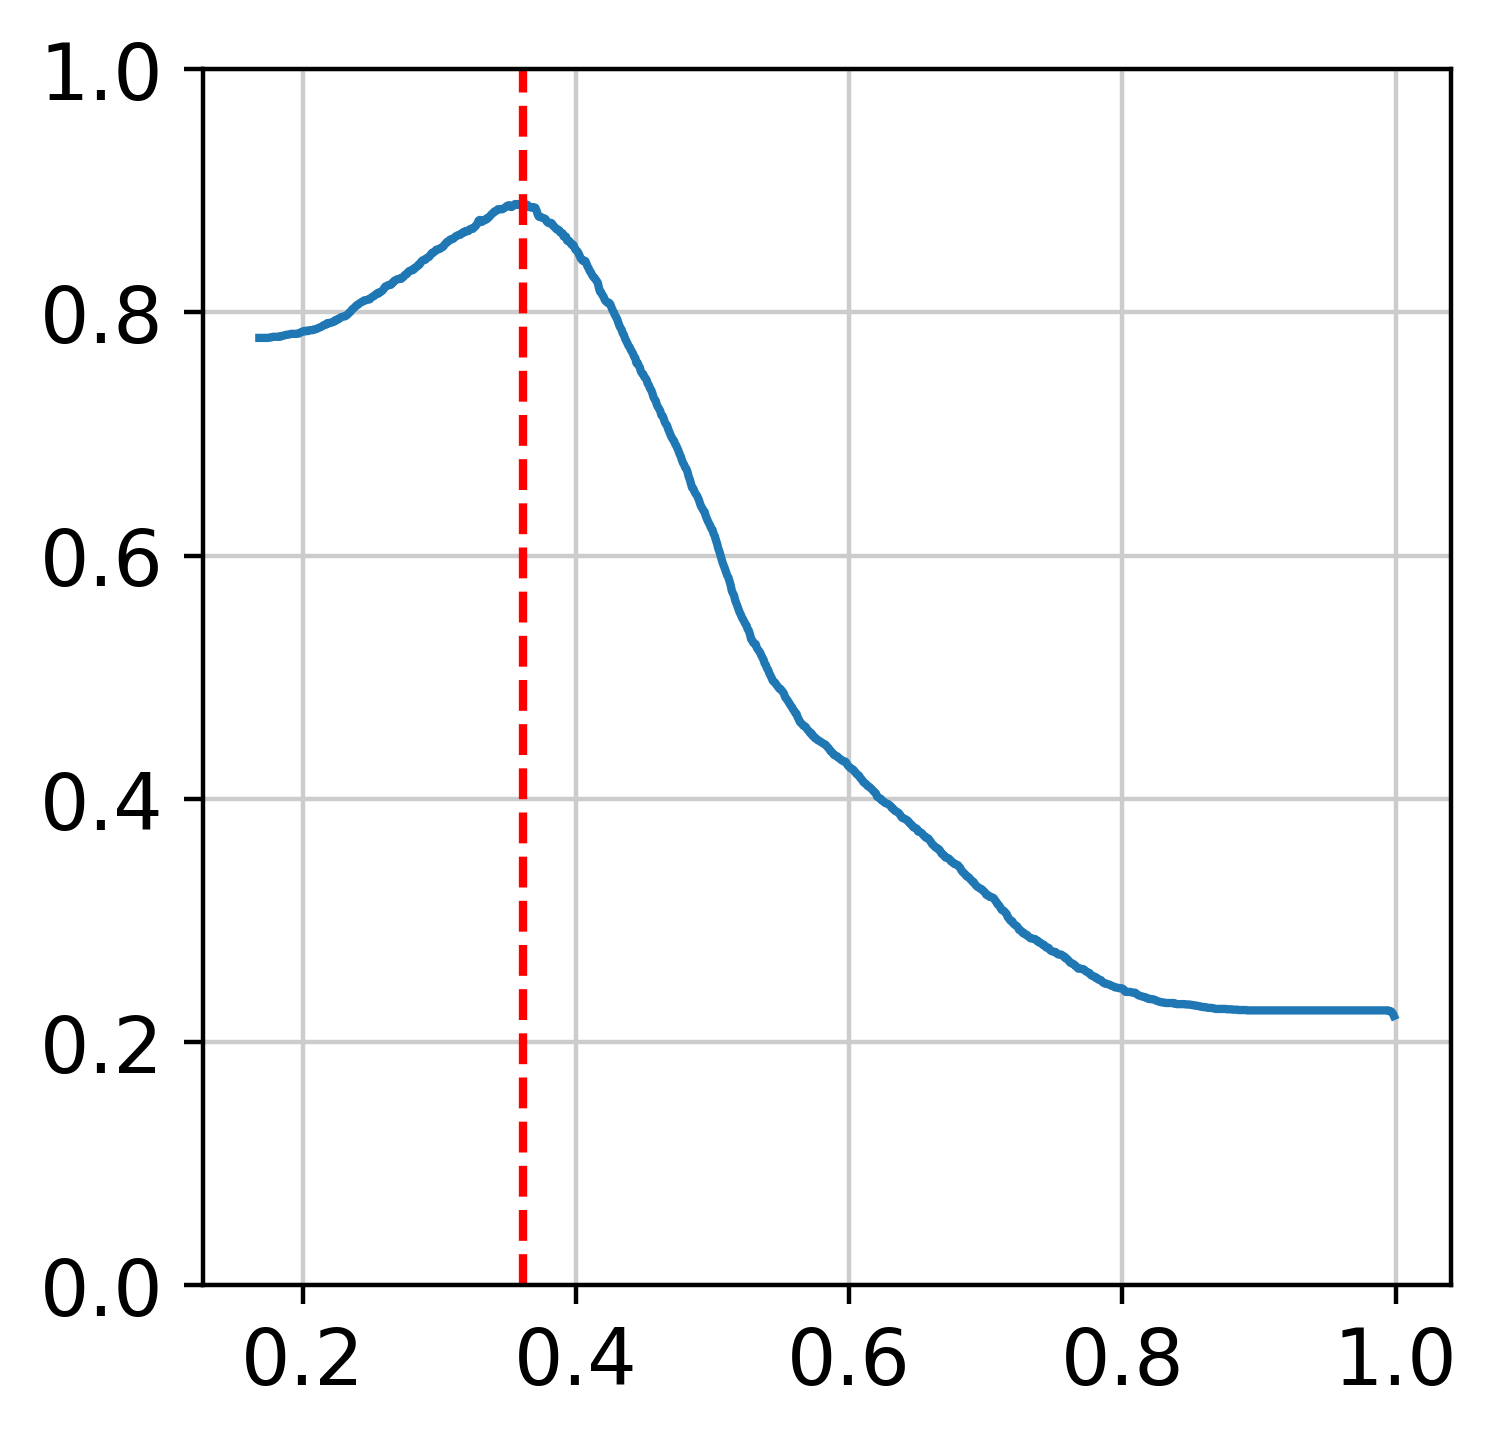

In [26]:
plt.plot(candidates, accs)
plt.axvline(candidates[np.argmax(accs)], color='r', linestyle='--')
plt.ylim([0, 1])

#### Get information for both landmark sets

In [27]:
labeled_set_euclidean = tranvae.get_landmarks_info()
labeled_set_euclidean.obs['study'] = 'labeled landmark euclidean'

In [28]:
unlabeled_set_euclidean = tranvae.get_landmarks_info(landmark_set='unlabeled')
unlabeled_set_euclidean.obs['study'] = 'unlabeled landmark euclidean'

#### Create adata object with cell  and landmark informations

In [29]:
data_latent = tranvae.get_latent()
adata_latent = sc.AnnData(data_latent)
adata_latent.obs[condition_key] = query_adata.obs[condition_key].tolist()
adata_latent.obs[cell_type_key] = query_adata.obs[cell_type_key].tolist()
adata_latent.obs[f'{cell_type_key}_pred'] = preds_q.tolist()
adata_latent.obs[f'{cell_type_key}_prob'] = probs_q.tolist()
adata_latent.obs[f'classifier_outcome'] = (
    adata_latent.obs[f'{cell_type_key}_pred'] == adata_latent.obs[f'{cell_type_key}']
)
probs_scaled = (probs_q - probs_q.min(axis=0)) / (probs_q.max(axis=0) - probs_q.min(axis=0))

adata_latent.obs[f'{cell_type_key}_prob_scaled'] = probs_scaled
adata_latent

AnnData object with n_obs × n_vars = 3289 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob', 'classifier_outcome', 'cell_type_prob_scaled'

In [30]:
full_latent = adata_latent.concatenate([
    labeled_set_euclidean, 
    unlabeled_set_euclidean,
])
full_latent

AnnData object with n_obs × n_vars = 3323 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob', 'classifier_outcome', 'cell_type_prob_scaled', 'batch'

#### Visualize Combined adata object

In [31]:
sc.pp.pca(full_latent)
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'study' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_pred' as categorical


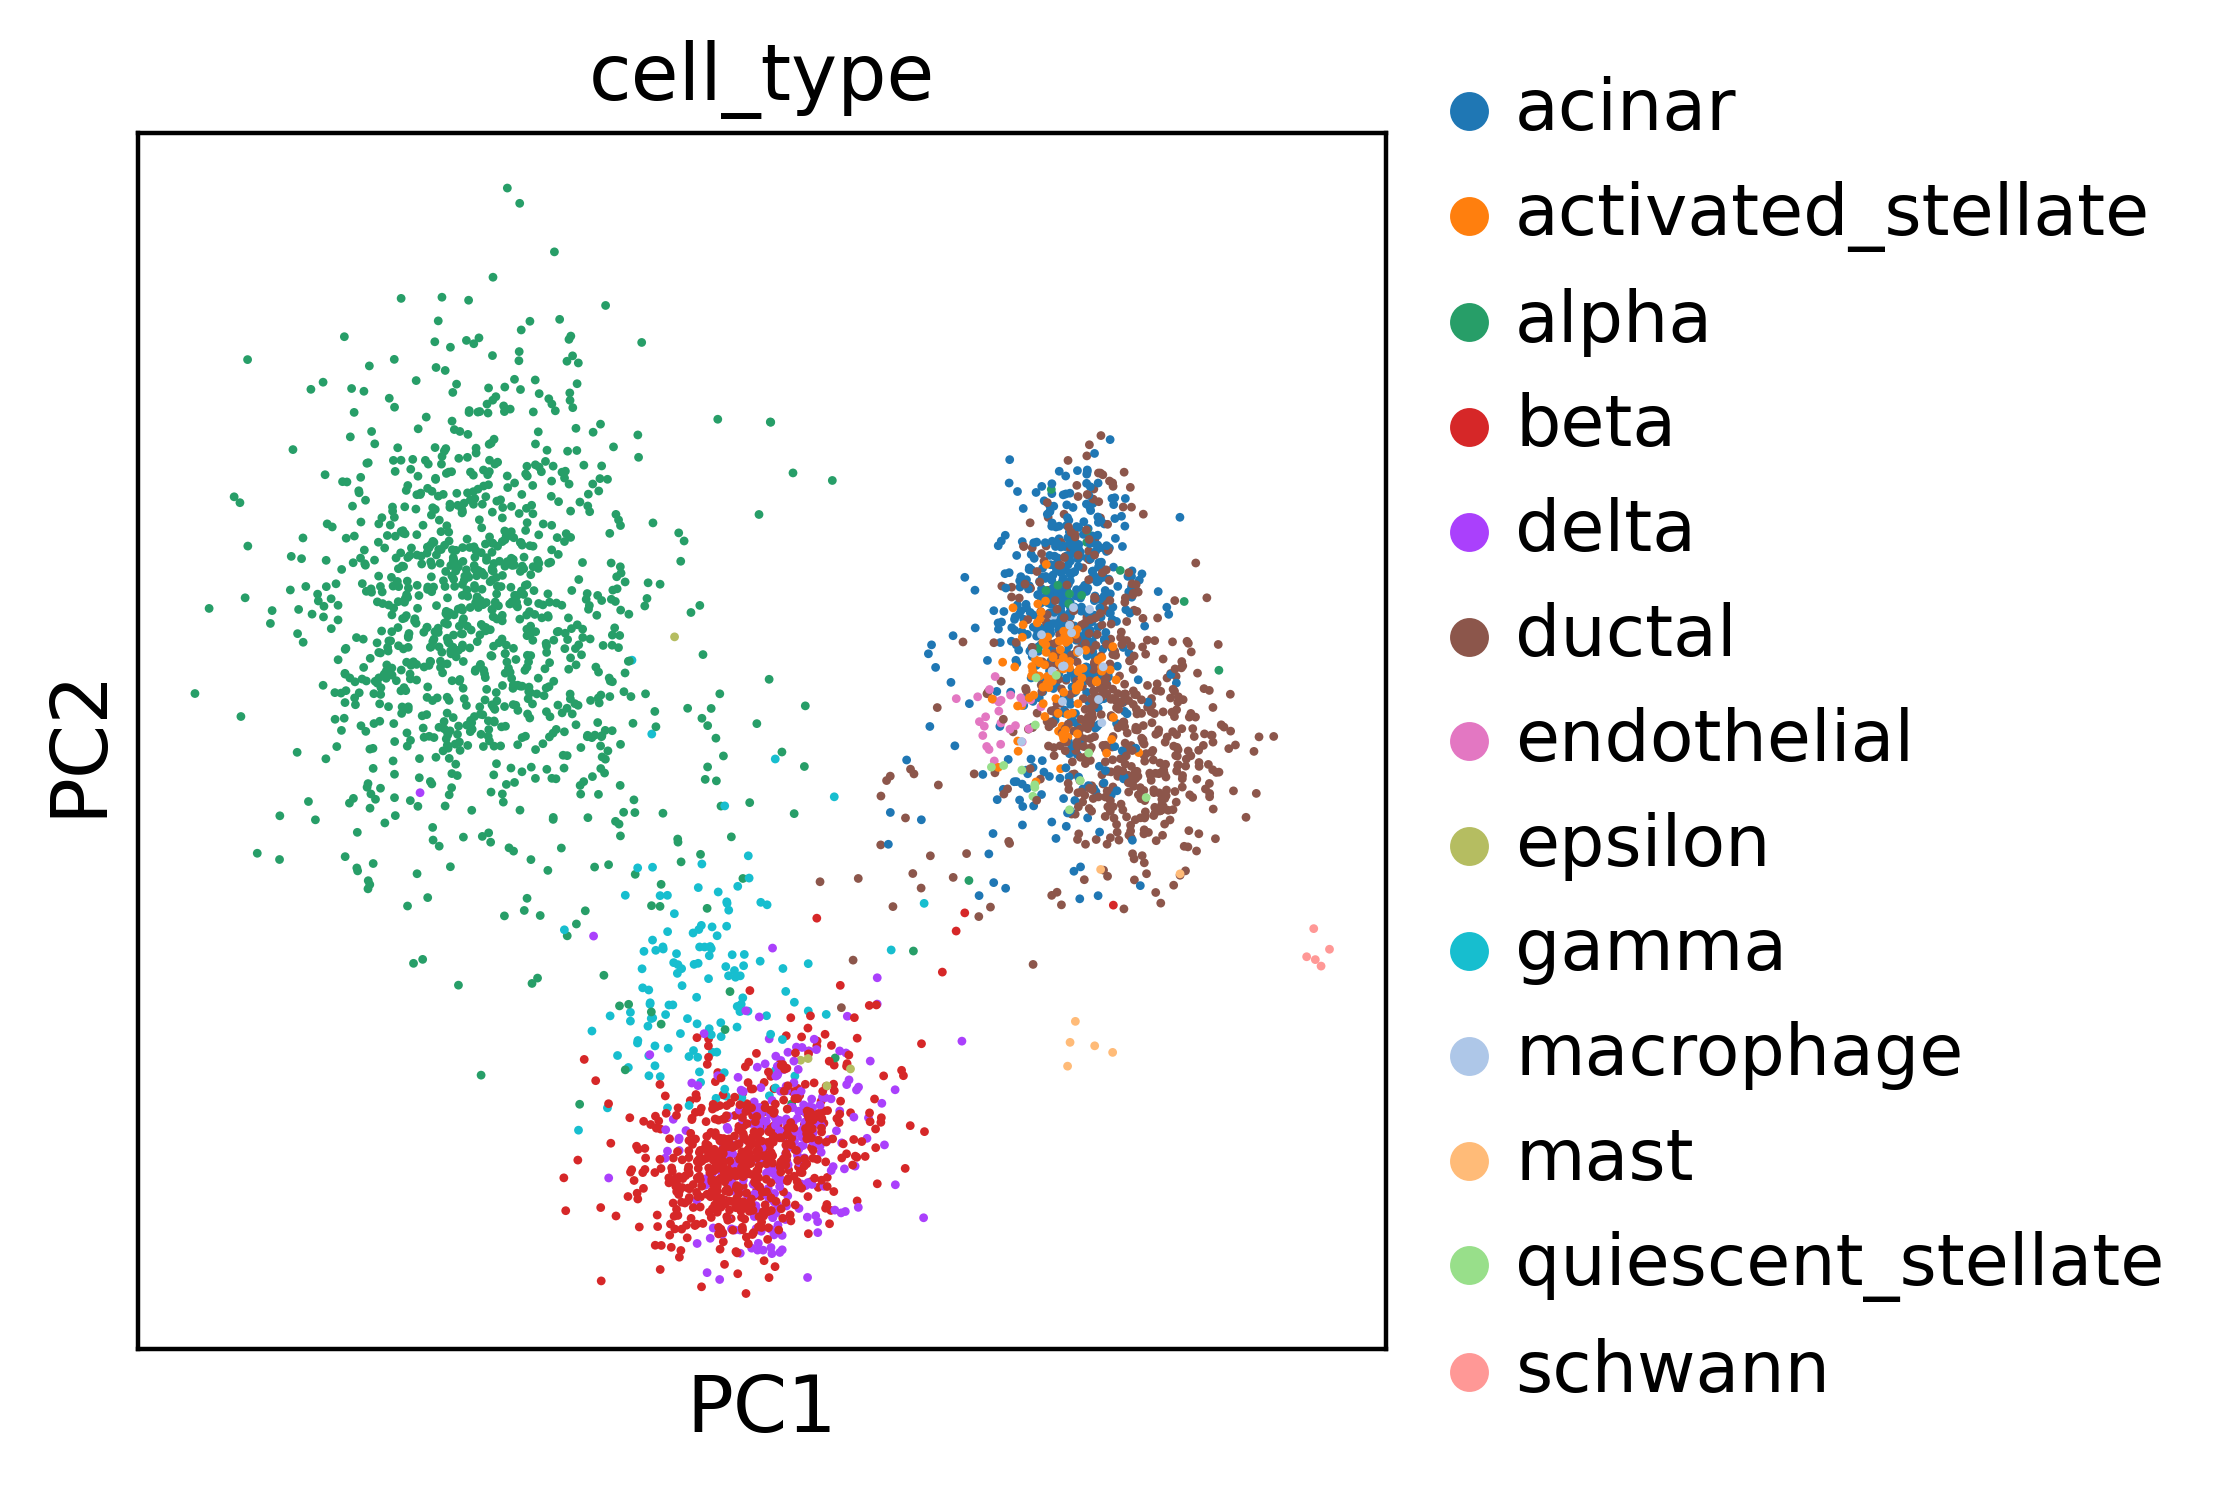

In [32]:
landmark_keys = [
    "labeled landmark euclidean",
    "unlabeled landmark euclidean"
]
sc.pl.pca(
    full_latent[~full_latent.obs[condition_key].isin(landmark_keys)],
    size=10,
    color=[cell_type_key],
)

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'study' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_pred' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'study' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_pred' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'study' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_pred' as categorical
Trying to set attribu

cell_type
cell_type_pred
cell_type_prob
cell_type_prob_scaled


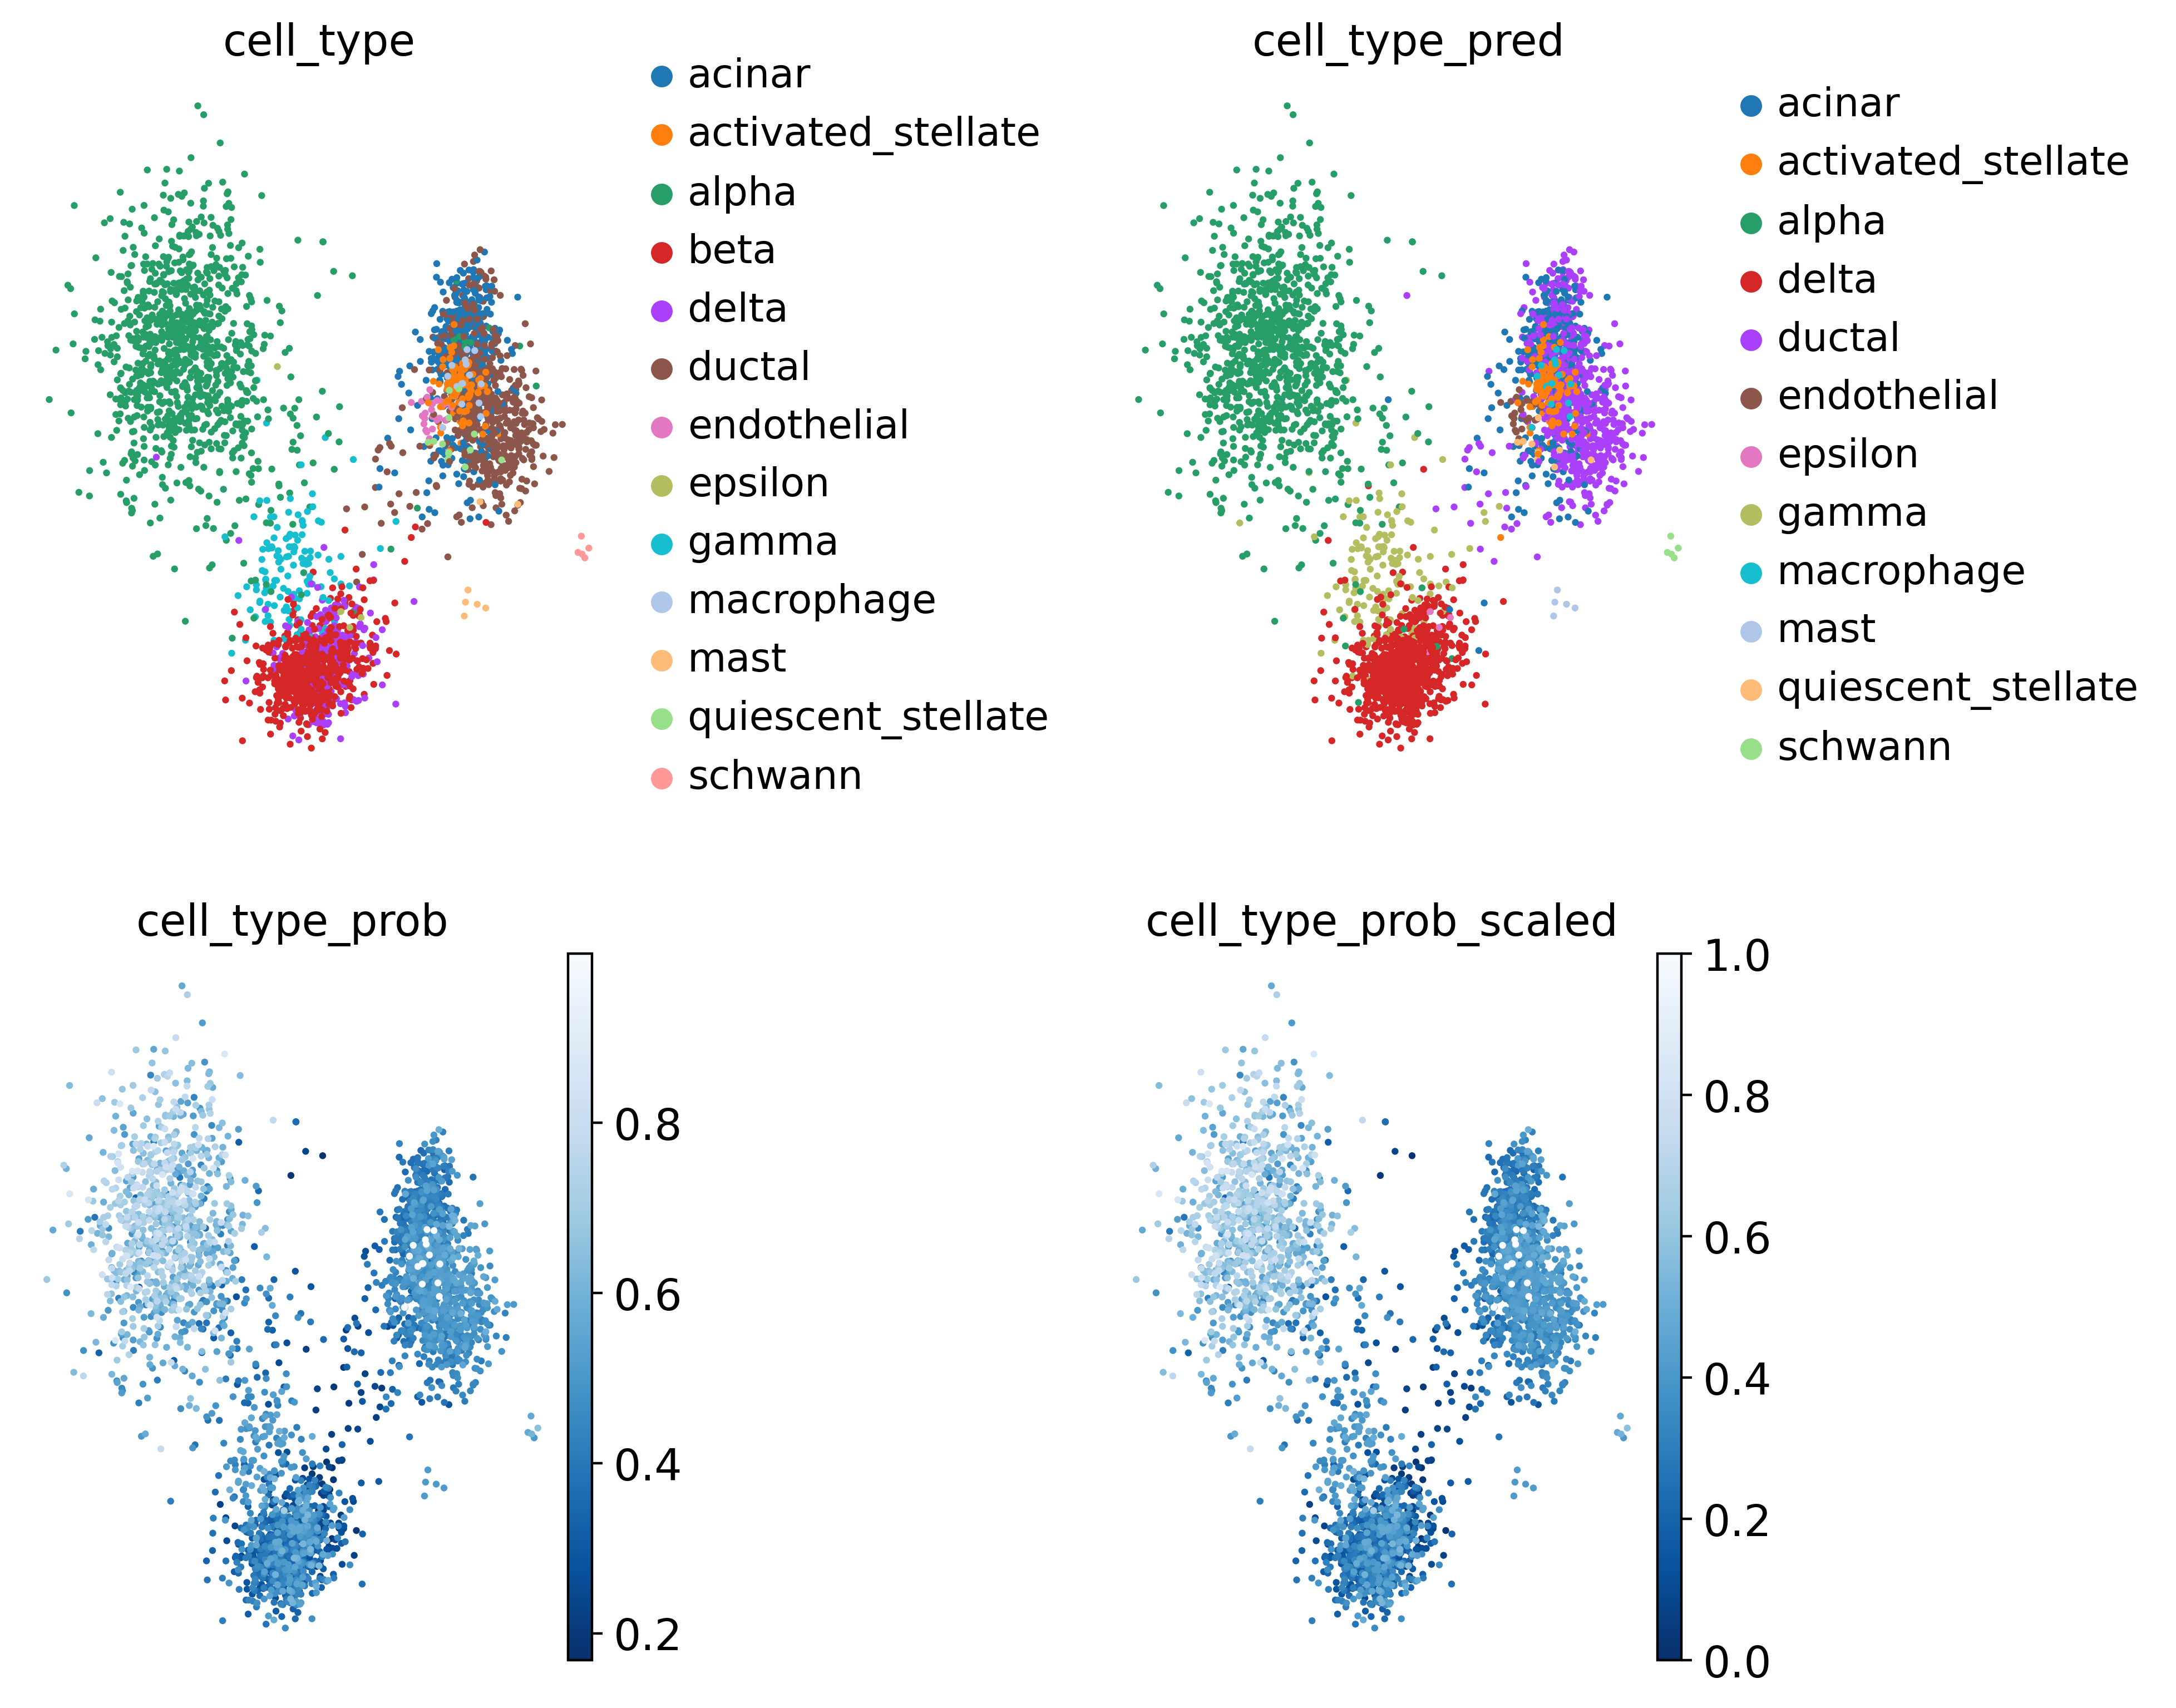

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax = ax.flatten()
plot_keys = [
    'cell_type', 
    'cell_type_pred',
    'cell_type_prob',
    'cell_type_prob_scaled'
]
sc.pp.pca(full_latent)
for i, key in enumerate(plot_keys):
    print(key)
    cmap = None
    if i > 1:
        cmap='Blues_r'
    sc.pl.pca(
        full_latent[~full_latent.obs[condition_key].isin(landmark_keys)], 
        color=key,
        size=20,
        show=False, 
        ax=ax[i],
        frameon=False,
        cmap=cmap
    )
    ax[i].set_title(key)
fig.tight_layout()

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


labeled landmark euclidean
unlabeled landmark euclidean


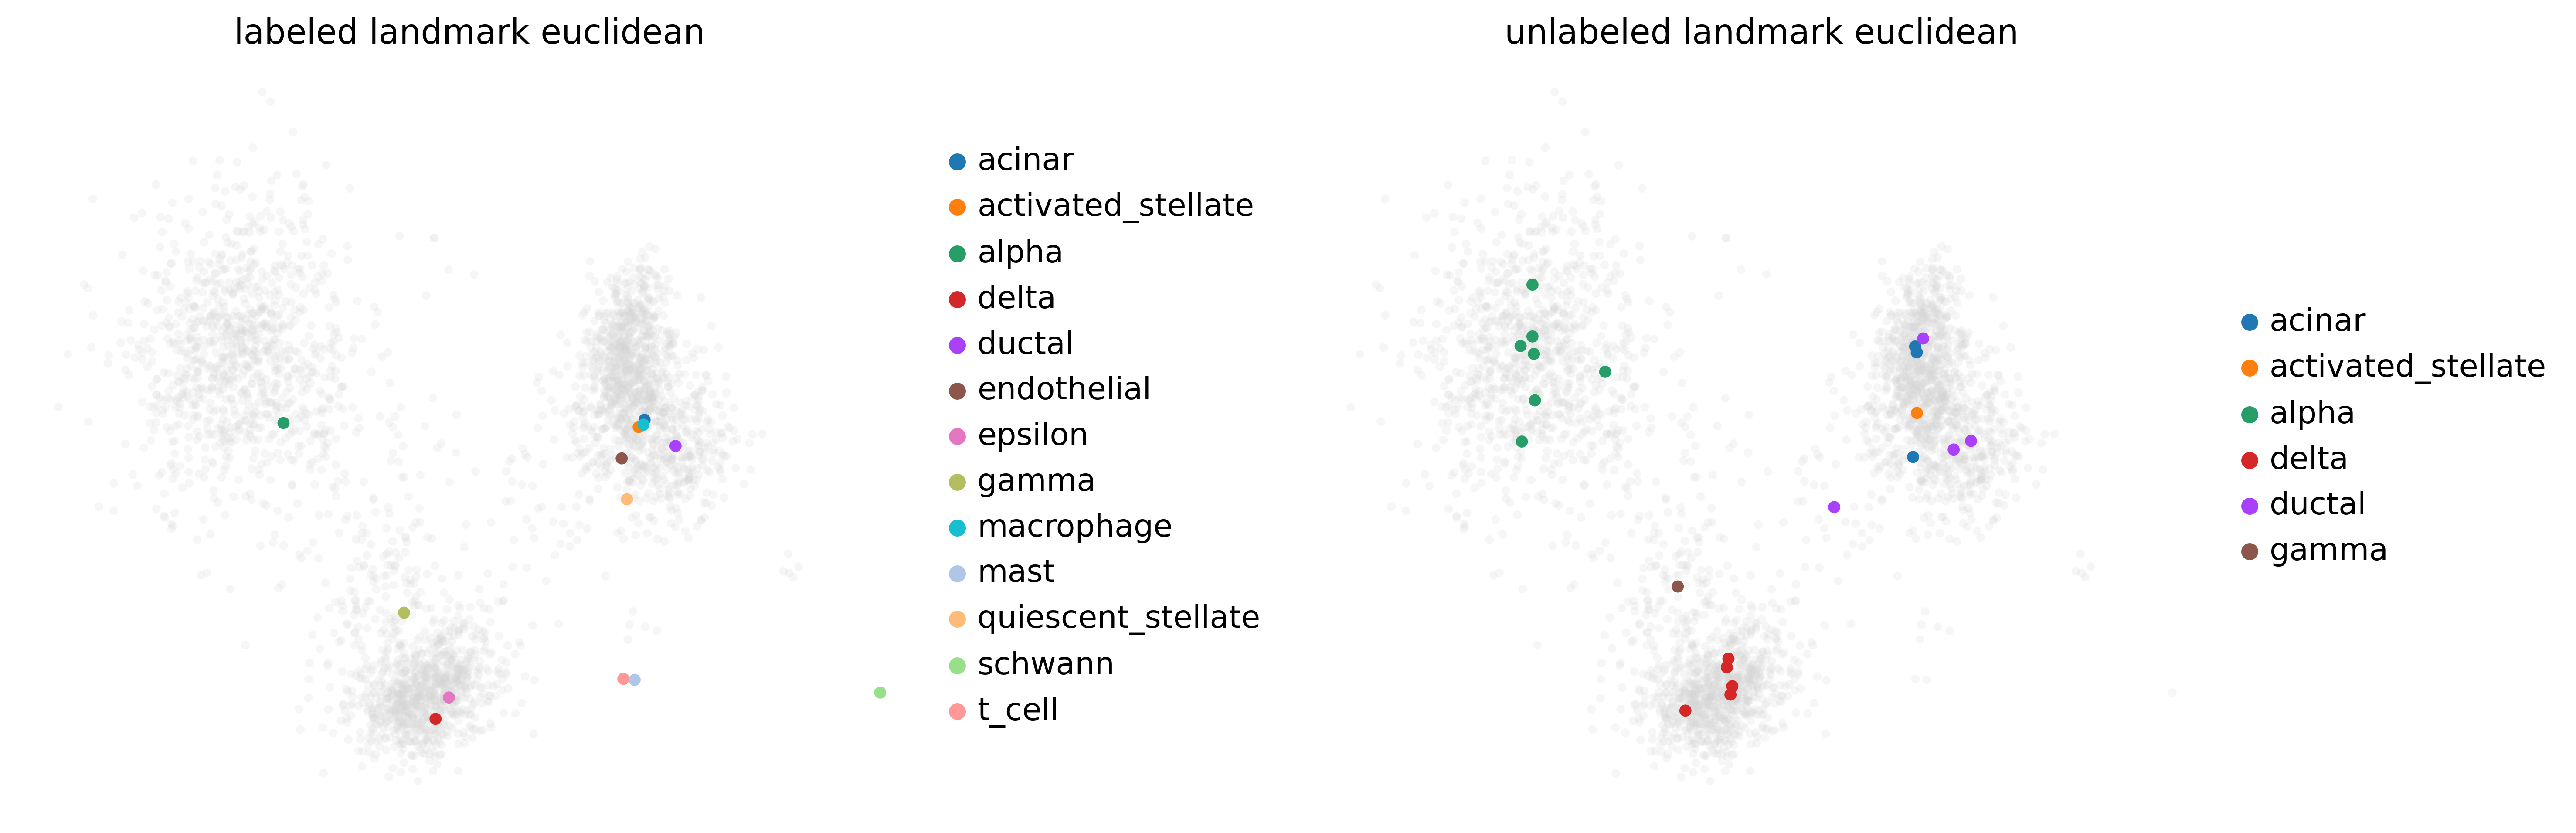

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.flatten()
sc.pp.pca(full_latent)
for i, key in enumerate(landmark_keys):
    print(key)
    sc.pl.pca(
        full_latent, 
        #color=cell_type_key,
        size=50,
        alpha=0.2, 
        show=False, 
        ax=ax[i]
    )
    ax[i].legend([])
    sc.pl.pca(
        full_latent[full_latent.obs[condition_key] == key],
        size=100,
        color=[cell_type_key + '_pred'],
        ax=ax[i],
        show=False,
        frameon=False,
    )
    ax[i].set_title(key)
fig.tight_layout()

Trying to set attribute `.uns` of view, copying.


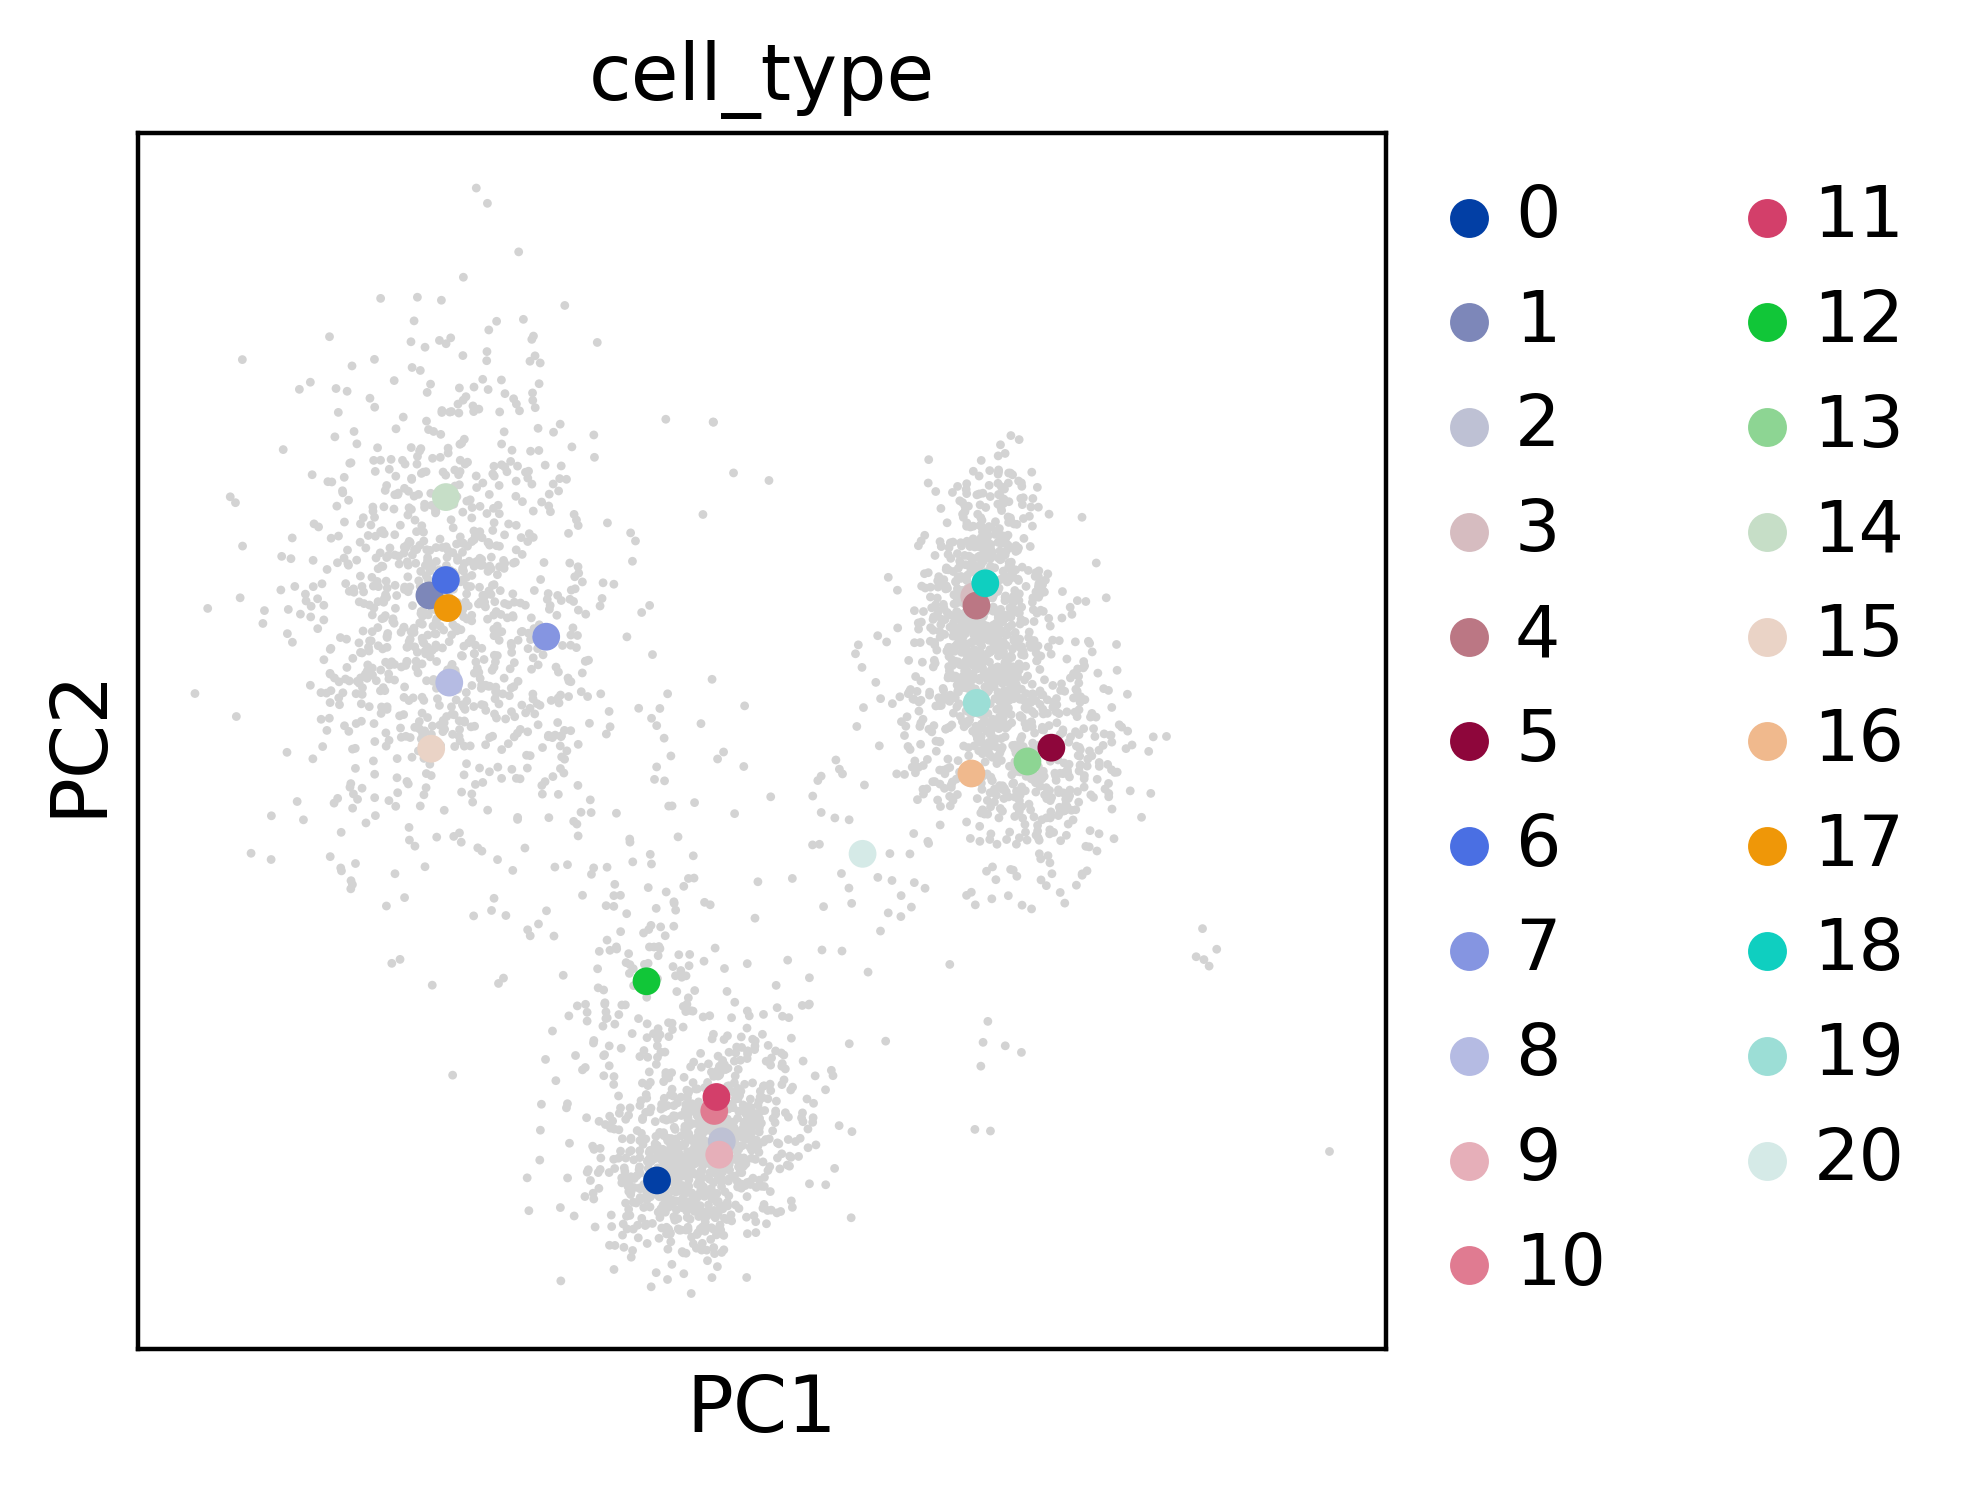

In [42]:
ax = sc.pl.pca(full_latent, size=10, show=False)
sc.pl.pca(
    full_latent[full_latent.obs[condition_key] == "unlabeled landmark euclidean"],
    size=100,
    color=[cell_type_key],
    ax=ax
)

# Unseen cell type detection

#### Check for novel cell types

In [43]:
unlabeled_set_euclidean.obs['novel'] = (unlabeled_set_euclidean.obs['cell_type_prob'] < 0.38).astype('category')

In [44]:
full_latent = adata_latent.concatenate([
    labeled_set_euclidean, 
    unlabeled_set_euclidean,
])
full_latent

AnnData object with n_obs × n_vars = 3323 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob', 'classifier_outcome', 'cell_type_prob_scaled', 'novel', 'batch'

... storing 'study' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_pred' as categorical


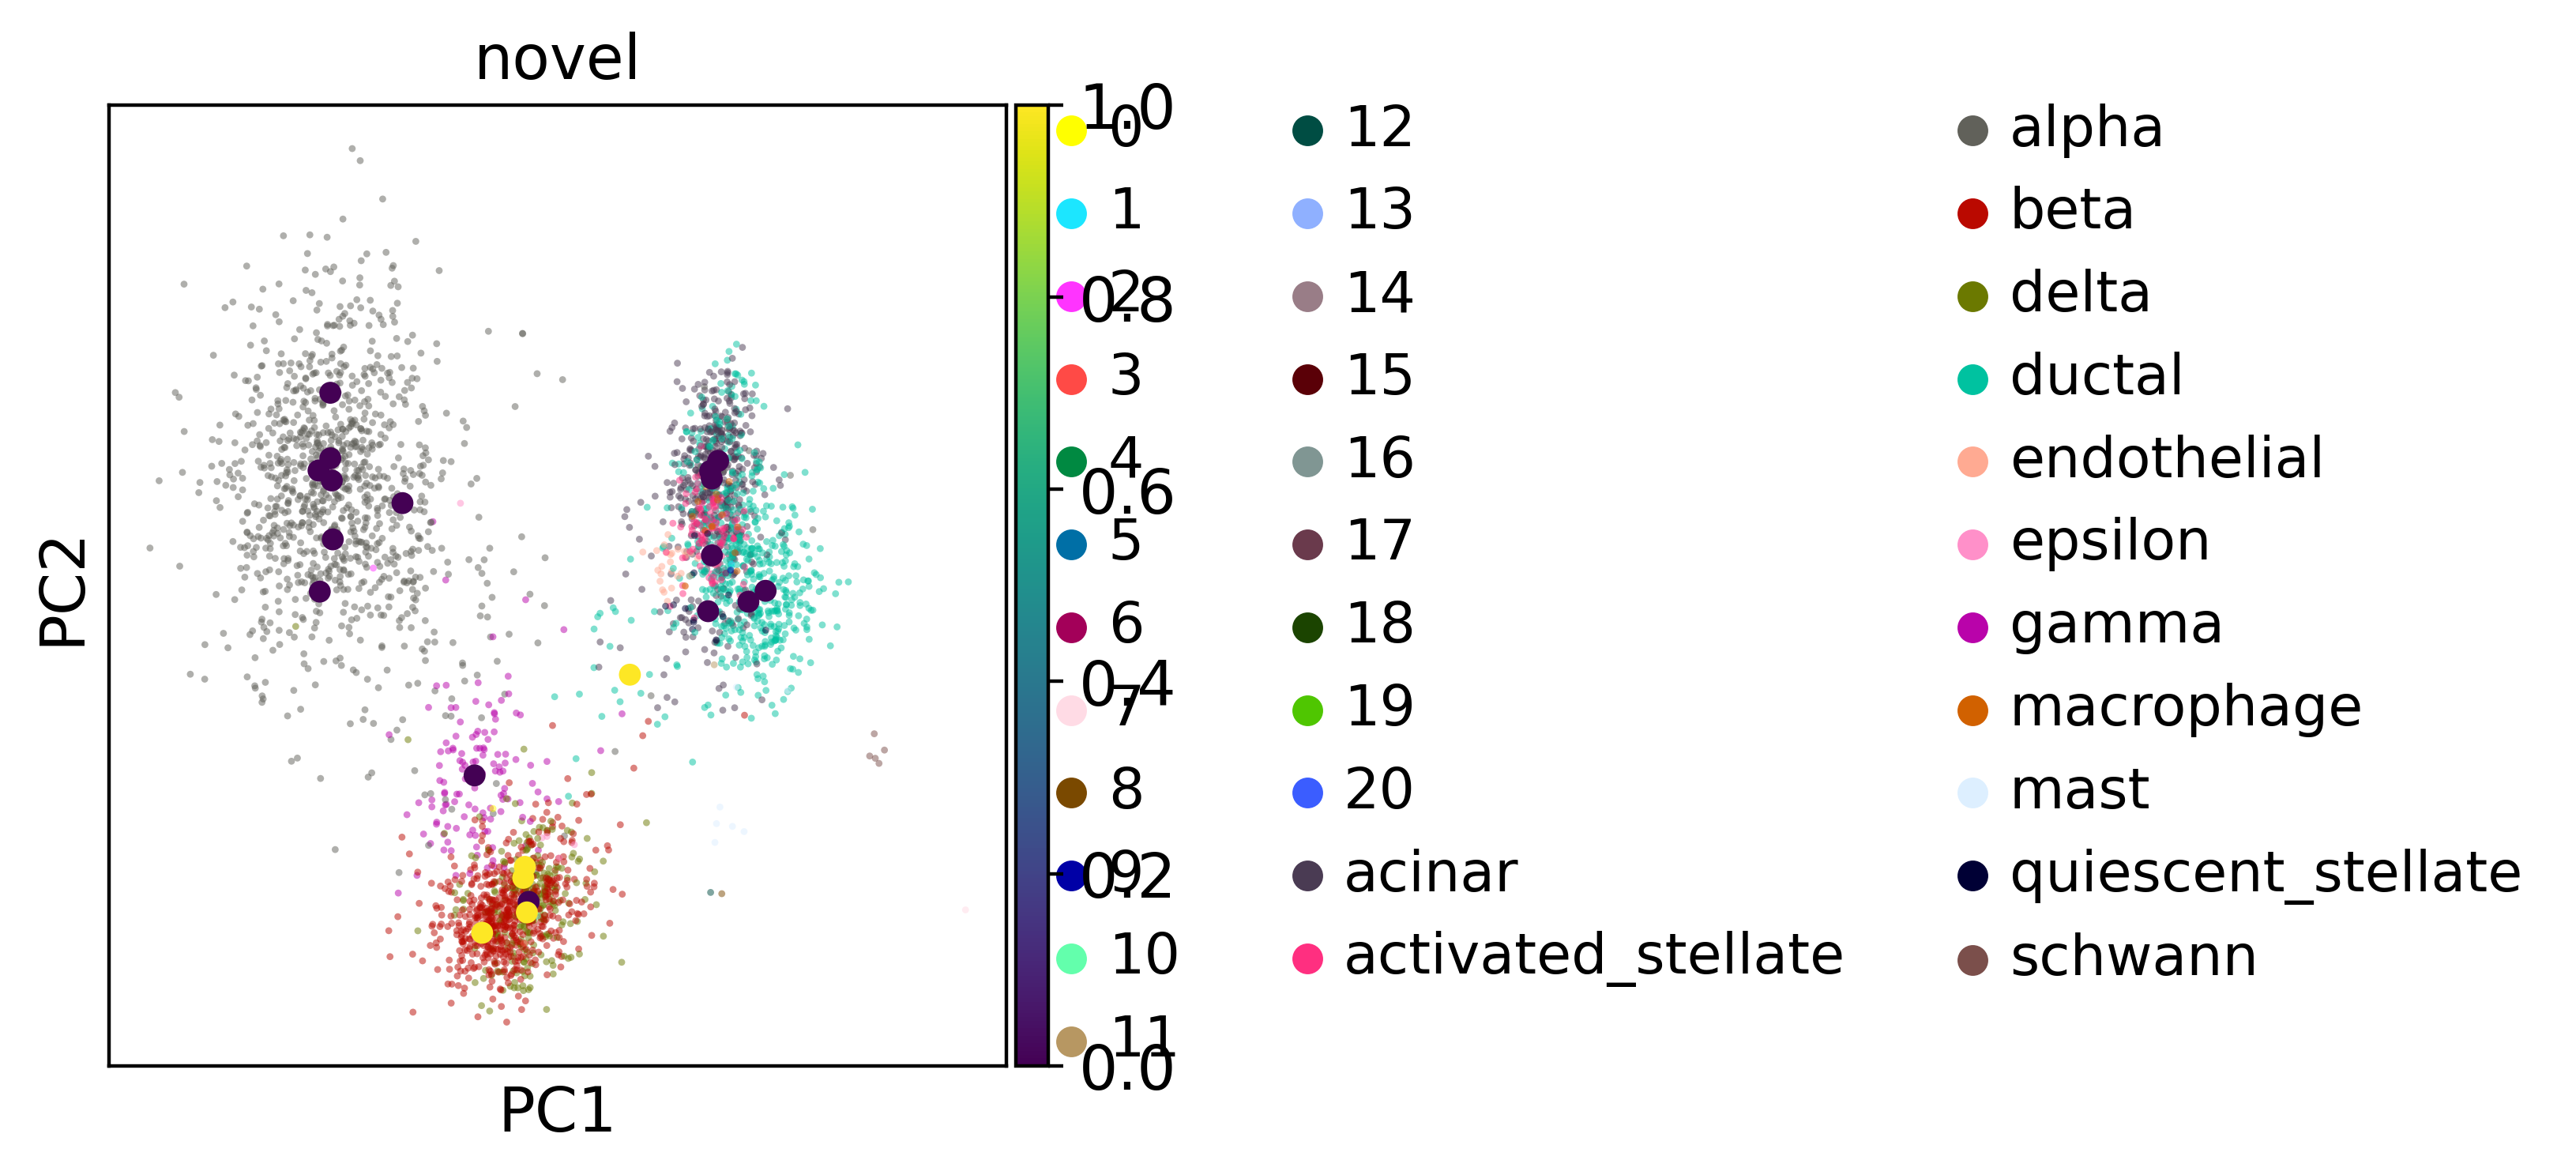

In [45]:
sc.pp.pca(full_latent)
ax = sc.pl.pca(full_latent, size=10, show=False, color='cell_type', alpha=0.5)
sc.pl.pca(
    full_latent[full_latent.obs[condition_key] == "unlabeled landmark euclidean"],
    size=100,
    color=['novel'],
    ax=ax
)

In [46]:
check = np.array(unlabeled_set_euclidean.obs[unlabeled_set_euclidean.obs['cell_type_prob']<0.38].index).astype(int)
check_shifted = check + len(adata_latent) + len(labeled_set_euclidean)

Trying to set attribute `.uns` of view, copying.


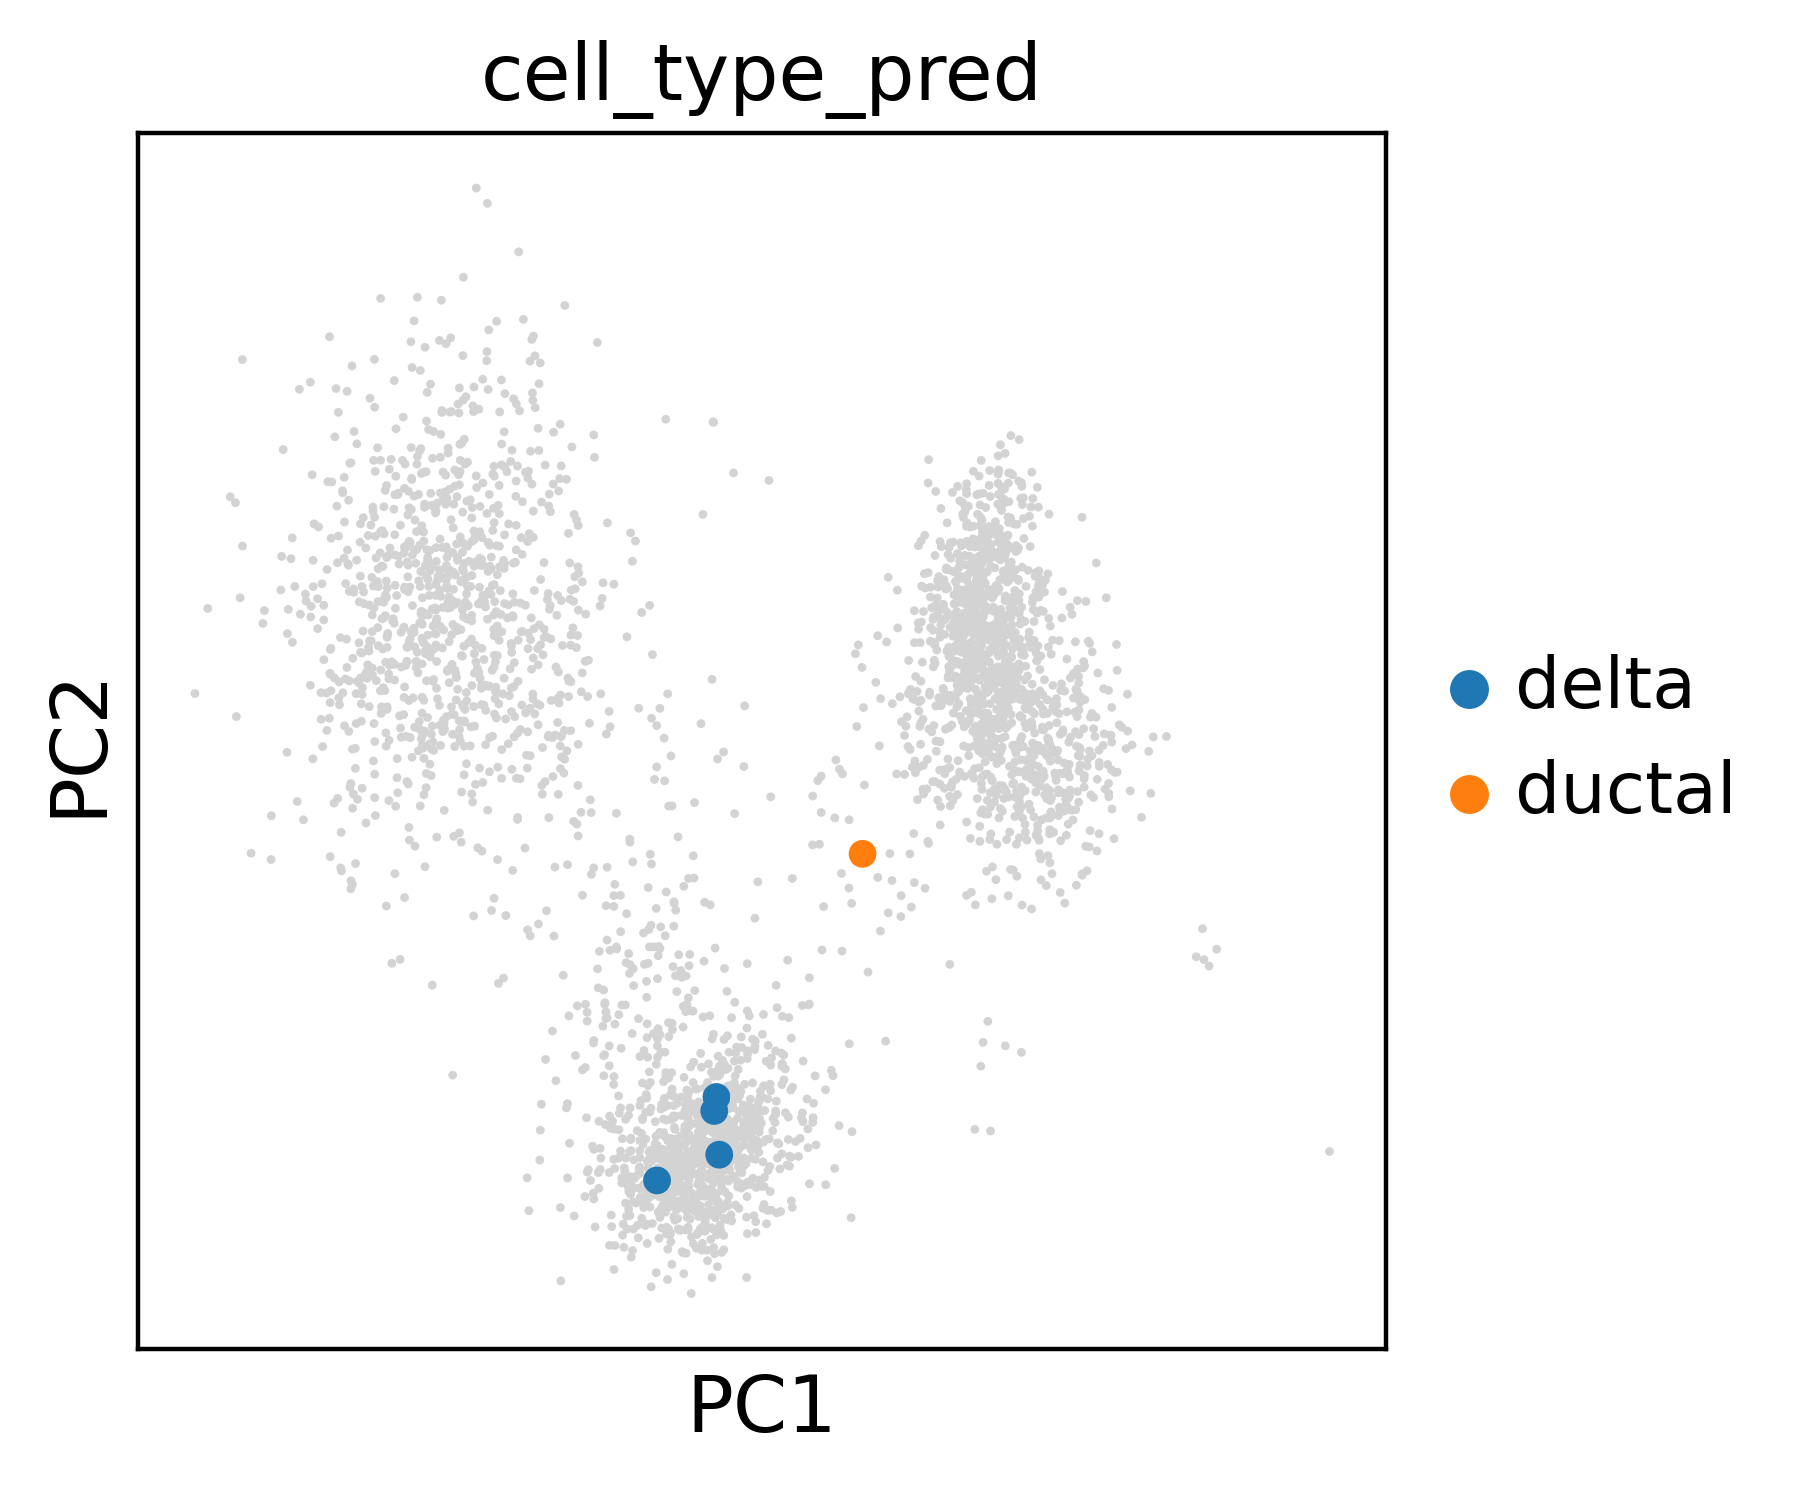

In [47]:
ax = sc.pl.pca(full_latent, size=10, show=False)

sc.pl.pca(
    full_latent[check_shifted],
    size=100,
    color=[cell_type_key + '_pred'],
    ax=ax
)

#### Add novel cell type with corresponding landmark(s) to the model

In [48]:
tranvae.add_new_cell_type(
    "beta", 
    cell_type_key, 
    check.tolist()
)

# Visualize results with updated model

In [49]:
results_dict = tranvae.classify(
)

preds = results_dict[cell_type_key]['preds']
probs = results_dict[cell_type_key]['probs']
print(classification_report(
    y_true=query_adata.obs[cell_type_key],
    y_pred=preds,
    labels=np.array(query_adata.obs[cell_type_key].unique().tolist())
))

                    precision    recall  f1-score   support

             gamma       0.98      0.98      0.98       128
            acinar       0.97      0.84      0.90       502
             alpha       1.00      0.96      0.98      1034
             delta       0.93      0.94      0.93       253
              beta       0.92      0.97      0.95       606
            ductal       0.87      0.96      0.91       585
       endothelial       1.00      1.00      1.00        26
activated_stellate       0.91      1.00      0.95       109
           schwann       1.00      1.00      1.00         5
              mast       1.00      0.71      0.83         7
        macrophage       1.00      0.94      0.97        16
           epsilon       1.00      0.80      0.89         5
quiescent_stellate       1.00      0.69      0.82        13

          accuracy                           0.94      3289
         macro avg       0.97      0.91      0.93      3289
      weighted avg       0.95      0.9

In [50]:
labeled_set = tranvae.get_landmarks_info(
    #metric="gaussian",
)
unlabeled_set = tranvae.get_landmarks_info(
    landmark_set='unlabeled',
    #metric="gaussian",
)
labeled_set

AnnData object with n_obs × n_vars = 14 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob'

In [51]:
results_dict = tranvae.classify(
    adata.X,
    adata.obs[condition_key],
    #metric="gaussian",
)

preds = results_dict[cell_type_key]['preds']
probs = results_dict[cell_type_key]['probs']
print(classification_report(
    y_true=adata.obs[cell_type_key],
    y_pred=preds,
    labels=np.array(adata.obs[cell_type_key].unique().tolist())
))
data_latent = tranvae.get_latent(
    adata.X,
    adata.obs[condition_key],
)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs[condition_key] = adata.obs[condition_key].tolist()
adata_latent.obs[cell_type_key] = adata.obs[cell_type_key].tolist()
adata_latent.obs[f'{cell_type_key}_pred'] = preds.tolist()
adata_latent.obs[f'{cell_type_key}_prob'] = probs.tolist()
full_latent = adata_latent.concatenate(labeled_set, unlabeled_set)

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                    precision    recall  f1-score   support

             gamma       0.93      1.00      0.96       699
            acinar       0.92      0.93      0.92      1669
             alpha       1.00      0.96      0.98      5493
             delta       0.97      0.96      0.96      1055
            ductal       0.94      0.93      0.94      2142
       endothelial       0.99      0.94      0.96       313
activated_stellate       0.93      0.99      0.96       464
           schwann       1.00      0.96      0.98        25
              mast       0.80      0.95      0.87        42
        macrophage       0.99      0.99      0.99        79
           epsilon       0.86      0.94      0.90        32
quiescent_stellate       0.89      0.94      0.91       193
            t_cell       0.00      0.00      0.00         7
              beta       0.75      0.96      0.84       606

          accuracy                           0.95     12819
         macro avg       0.85      0.8

In [52]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'study' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_pred' as categorical


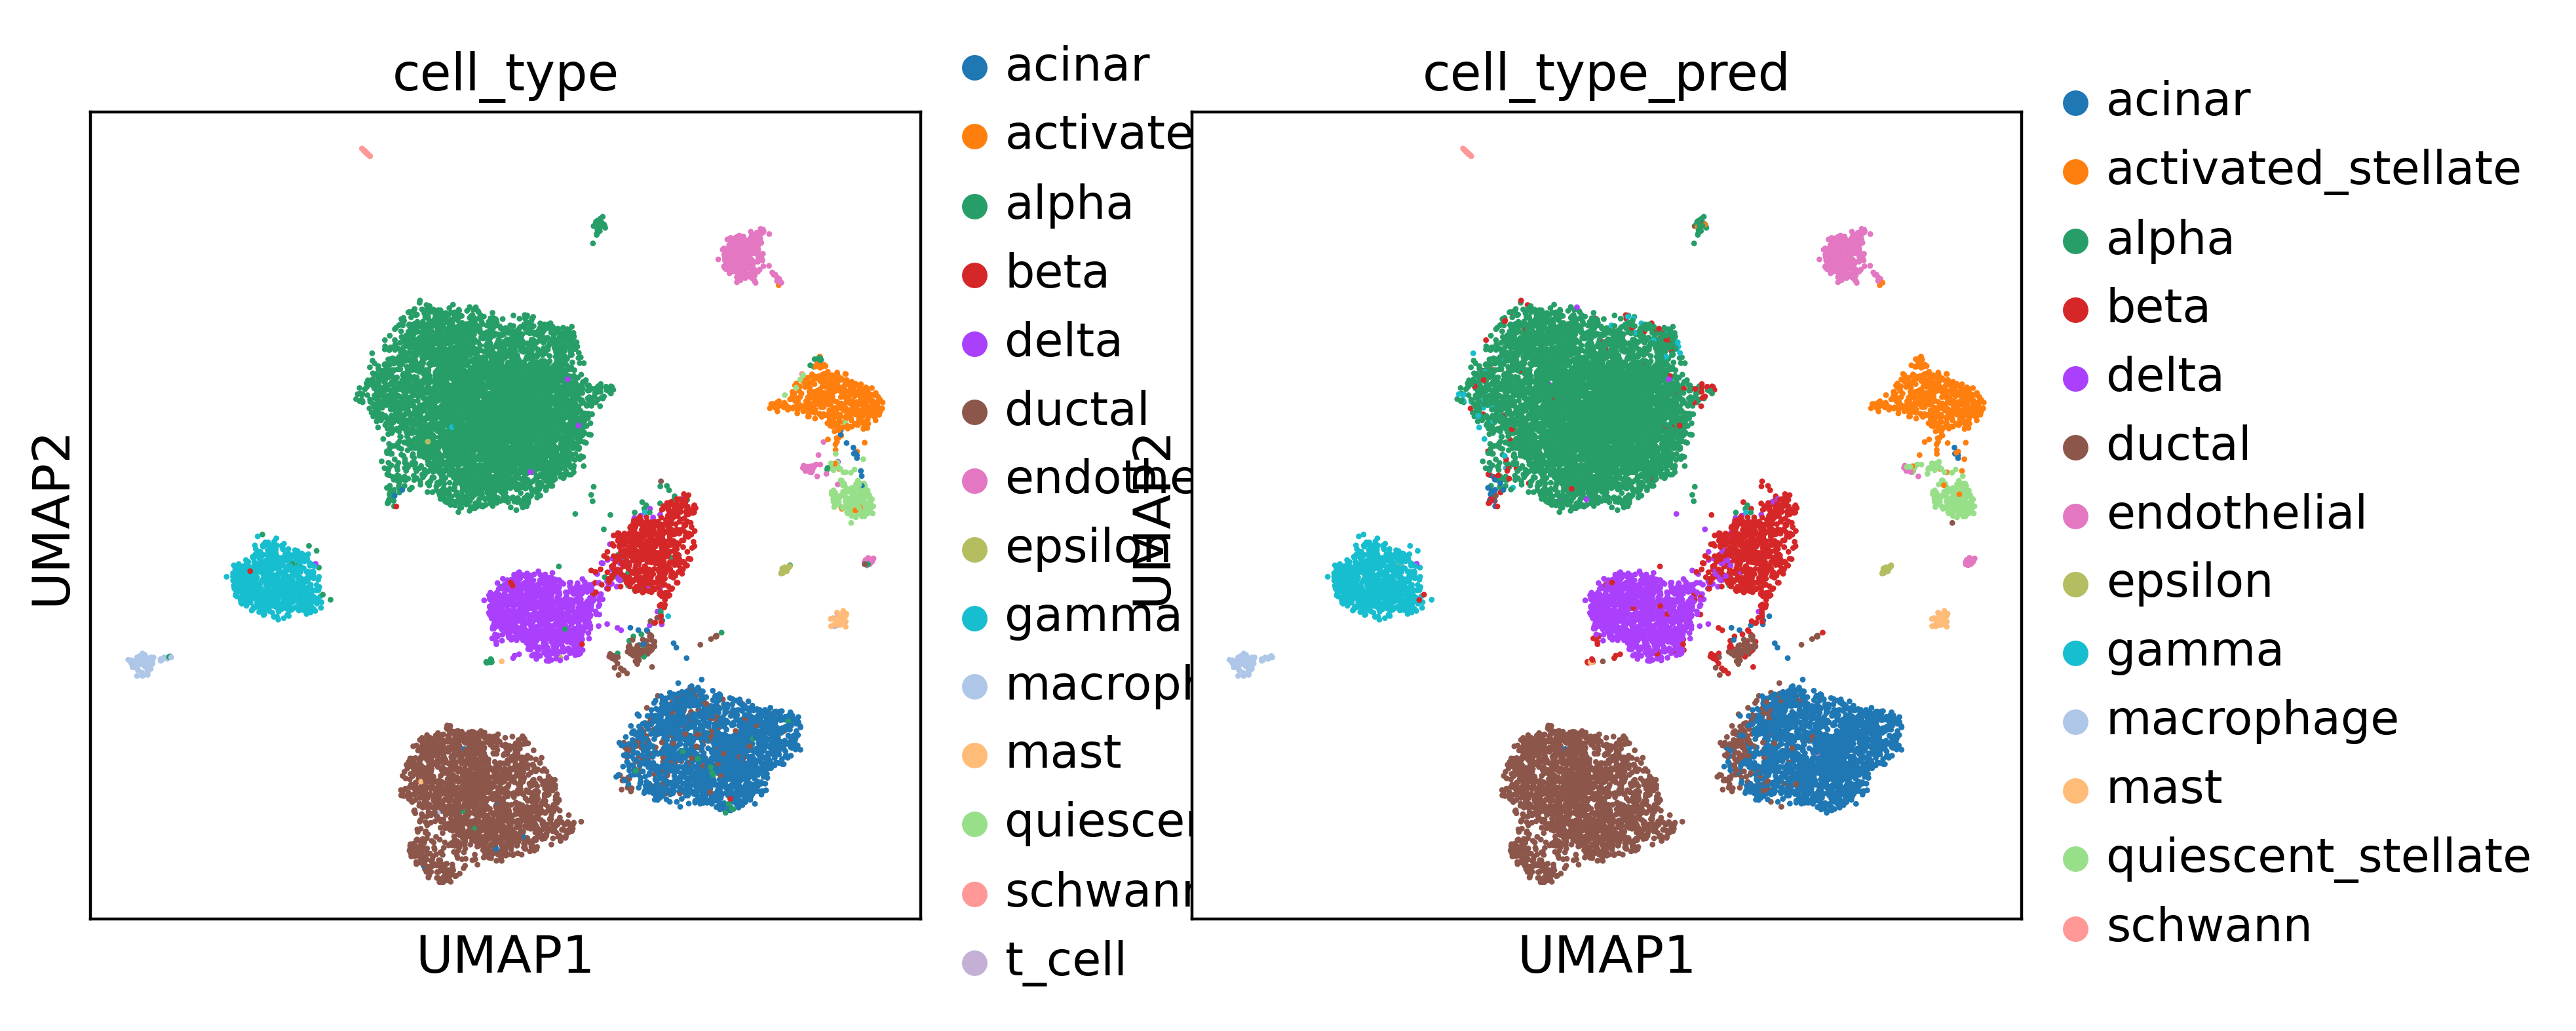

In [53]:
landmark_keys = ["Landmark-Set Unlabeled","Landmark-Set Labeled"]
sc.pl.umap(
    full_latent[~full_latent.obs[condition_key].isin(landmark_keys)],
    size=10,
    color=[cell_type_key, 'cell_type_pred'],
)

... storing 'study' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_pred' as categorical
Trying to set attribute `.uns` of view, copying.


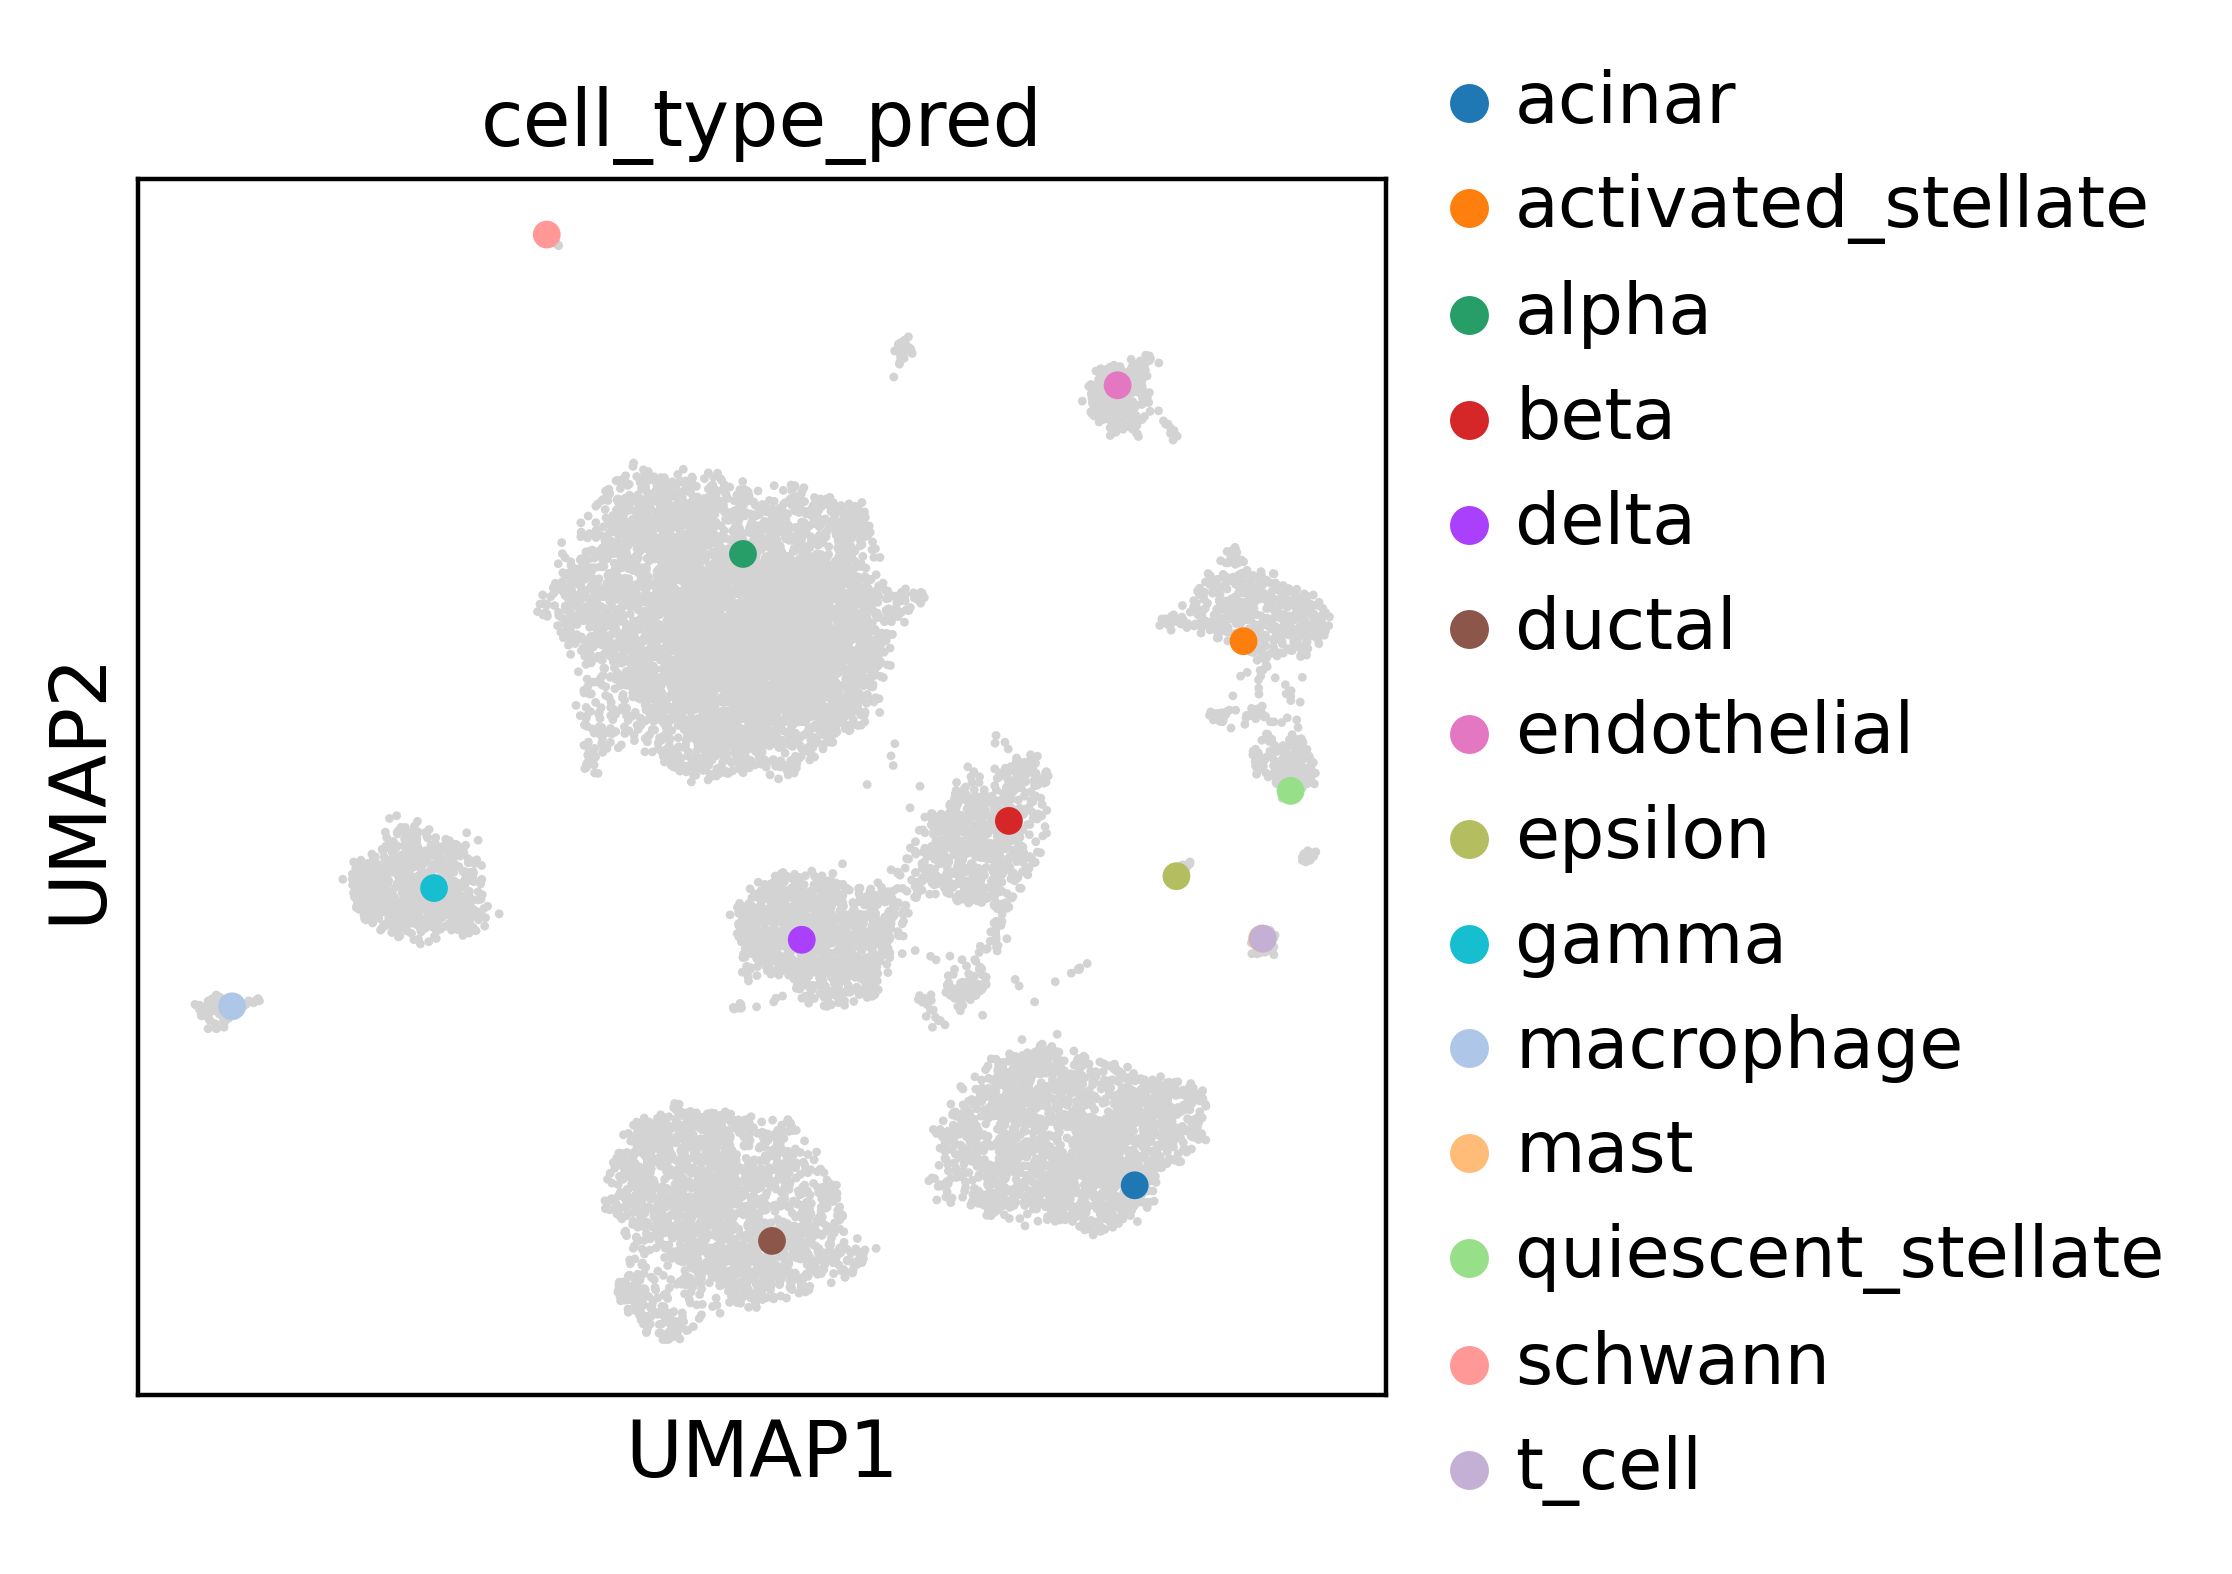

In [54]:
ax = sc.pl.umap(full_latent, size=10, show=False)
sc.pl.umap(
    full_latent[full_latent.obs[condition_key] == "Landmark-Set Labeled"],
    size=100,
    color=[cell_type_key + '_pred'],
    ax=ax
)